In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [2]:
name = 'MotifSimulation_binary'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, 'N=300000_S=200_M=20_G=20_data.pickle')
train, valid, test = load_data(name, filepath)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [4]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.18978 -- accuracy=94.92%  
  valid loss:		0.14699
  valid accuracy:	0.95423+/-0.01811
  valid auc-roc:	0.84455+/-0.10979
  valid auc-pr:		0.32893+/-0.22705
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.10429 -- accuracy=96.37%  
  valid loss:		0.07999
  valid accuracy:	0.97082+/-0.01385
  valid auc-roc:	0.95366+/-0.05615
  valid auc-pr:		0.66343+/-0.25675
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.07188 -- accuracy=97.36%  
  valid loss:		0.06285
  valid accuracy:	0.97688+/-0.01190
  valid auc-roc:	0.97233+/-0.03467
  valid auc-pr:		0.75925+/-0.23796
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000

In [5]:
nnmodel.print_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 4, 200, 1)
layer2: 
shape:(None, 20, 200, 1)
parameters: W
layer3: 
shape:(None, 20, 200, 1)
parameters: b
layer4: 
shape:(None, 20, 200, 1)
layer5: 
shape:(None, 20, 50, 1)
layer6: 
shape:(None, 40, 50, 1)
parameters: W
layer7: 
shape:(None, 40, 50, 1)
parameters: b
layer8: 
shape:(None, 40, 50, 1)
layer9: 
shape:(None, 40, 25, 1)
layer10: 
shape:(None, 200)
parameters: W
layer11: 
shape:(None, 200)
parameters: b
layer12: 
shape:(None, 200)
layer13: 
shape:(None, 20)
parameters: W
layer14: 
shape:(None, 20)
parameters: b
layer15: 
shape:(None, 20)
----------------------------------------------------------------------------


In [795]:
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer

In [7]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f54487e51d0>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5435e05890>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7f54487c4b50>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f5435e12d90>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f5435e05a50>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5435e05a90>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7f5435e05ad0>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f5435e24050>,
 'dense1': <lasagne.layers.dense.DenseLayer at 0x7f5435e24090>,
 'dense1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5435e24510>,
 'dense1_bias': <lasagne.layers.special.BiasLayer at 0x7f54ac6636d0>,
 'input': <lasagne.layers.input.InputLayer at 0x7f54487e5150>,
 'output': <lasagne.layers.special.NonlinearityLayer at 0x7f5435e24810>,
 'output_bias': <lasagne.layers.special.BiasLayer at 0x7f5435e246d0>}

In [9]:

def seq_logo(pwm, height=100, width=200, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                correction = 3/2
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
            
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)

    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    nt_width = np.floor(width/num_seq).astype(int)
    logo = np.ones((height, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = height;
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        
        for j in range(num_nt):
            # resized dimensions of image
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)



def plot_conv_filter(plt, pwm, height=200, bp_width=100, norm=0, rna=1, adjust=-1, filepath='.', showbar=0):
    num_seq = pwm.shape[1]
    width = bp_width*num_seq

    logo = seq_logo(pwm, height, width, norm, rna, filepath)
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].imshow(logo, extent=[bp_width*2, width+bp_width, 0, height])
    axes[0].set_axis_off()
    im = axes[1].imshow(pwm, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    axes[1].set_axis_off()
    fig.subplots_adjust(bottom=adjust)
    if showbar == 1:
        cbar_ax = fig.add_axes([.85, 0.05, 0.05, 0.45])
        cb = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
        cb.ax.tick_params(labelsize=16)
    return fig

def fig_options(plt, options):
    if 'figsize' in options:
        fig = plt.gcf()
        fig.set_size_inches(options['figsize'][0], options['figsize'][1], forward=True)
    if 'ylim' in options:
        plt.ylim(options['ylim'][0],options['ylim'][1])
    if 'yticks' in options:
        plt.yticks(options['yticks'])
    if 'xticks' in options:
        plt.xticks(options['xticks'])
    if 'labelsize' in options:        
        ax = plt.gca()
        ax.tick_params(axis='x', labelsize=options['labelsize'])
        ax.tick_params(axis='y', labelsize=options['labelsize'])
    if 'axis' in options:
        plt.axis(options['axis'])
    if 'xlabel' in options:
        plt.xlabel(options['xlabel'], fontsize=options['fontsize'])
    if 'ylabel' in options:
        plt.ylabel(options['ylabel'], fontsize=options['fontsize'])
    if 'linewidth' in options:
        plt.rc('axes', linewidth=options['linewidth'])
        

def subplot_grid(nrows, ncols):
    grid= mpl.gridspec.GridSpec(nrows, ncols)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    return grid


def get_weights(layer, convert_pwm=0):
    W =  np.squeeze(layer.W.get_value())
    W_norm = W
    if convert_pwm == 1:
        for i in range(len(W)):
            #weights = np.exp(W[i])
            MIN = np.min(W[i])
            weights = W[i] - MIN
            Z = np.sum(weights, axis=0)
            weights /= np.tile(Z, (W[i].shape[0],1))
            W_norm[i] = weights
    return W_norm

def plot_conv_weights(W, options):
    num_filters = W.shape[0]
    nrows = np.ceil(np.sqrt(num_filters)).astype(int)
    ncols = nrows
    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_filters):
        plt.subplot(grid[i])
        plt.imshow(W[i], cmap='hot_r', interpolation='nearest')
        fig_options(plt, options)
    return plt

def batch_generator(X, y, batch_size=128, shuffle=True):
    """python generator to get a randomized minibatch"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype('float32'), y[excerpt].astype('int32')


def get_feature_map_all(layer, input_var, X, batch_size=500):
    num_data = len(X)
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size=500
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    if excess:
        index = range(num_data-excess, num_data)  
        fmaps[index] = feature_maps(X[index])
    return fmaps

def get_feature_map(layer, input_var, X, index):
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    
    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    return feature_maps(X[index])


/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


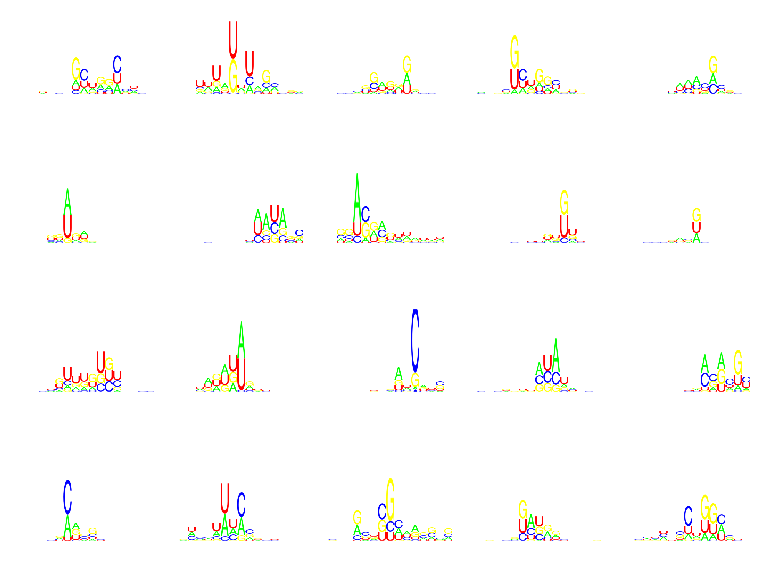

In [10]:
# plot convolutional filter --> sequence logo
W = get_weights(network['conv1'], convert_pwm=1)

num_filters = W.shape[0]
nrows = np.ceil(np.sqrt(num_filters)).astype(int)
ncols = nrows
height=300
bp_width=30
adjust=-1.5,
size = (100.0, 100.0)
fig = plt.figure(figsize=size)
fig.set_size_inches(size[0],size[1], forward=True);
grid= mpl.gridspec.GridSpec(nrows, ncols)
grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2)     
for i in range(num_filters):
    plt.subplot(grid[i])

    MIN = np.min(W[i])
    MAX = np.max(W[i])
    pwm = (W[i] - MIN)/(MAX-MIN)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    num_seq = pwm.shape[1]
    width = bp_width*num_seq
    logo = seq_logo(pwm, height, width, norm=0, rna=1, filepath='.')
    plt.imshow(logo, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    plt.axis('off')
    

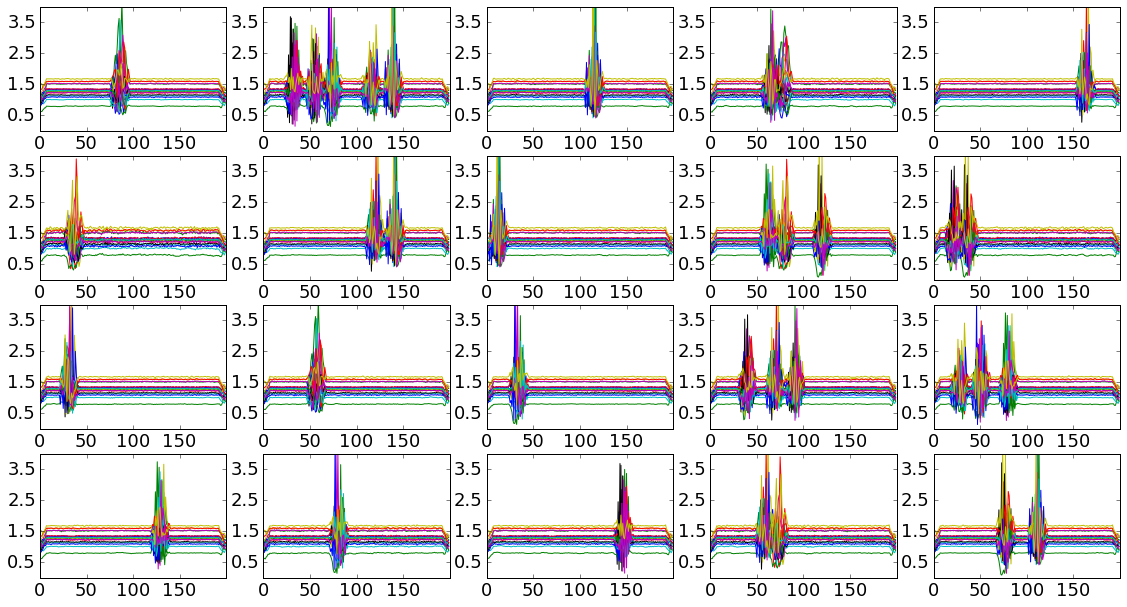

In [10]:
def get_class_activation(fmaps, y, batch_size=512):
    fmaps = np.squeeze(fmaps)
    mean_activation = []
    std_activation = []
    for i in range(y.shape[1]):
        index = np.where(y[:,i] == 1)[0]
        mean_activation.append(np.nanmean(fmaps[index], axis=0))
        std_activation.append(np.nanstd(fmaps[index], axis=0))
    return np.array(mean_activation), np.array(std_activation)


def plot_mean_activations(mean_activation, options):
    num_labels = len(mean_activation)
    nrows = np.ceil(np.sqrt(num_labels)).astype(int)
    ncols = nrows

    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_labels):
        plt.subplot(grid[i])
        plt.plot(mean_activation[i].T)
        fig_options(plt, options)
    return plt


fmaps = get_feature_maps(network['conv1_active'], nnmodel.input_var, train[0])
mean_activation, std_activation = get_class_activation(fmaps, train[1])
options = { 'ylim': [0, 4],
            'xticks': [0, 50, 100, 150],
            'yticks': [0.5, 1.5, 2.5, 3.5],
            'labelsize': 18,
            'figsize': (150,100)}
plt = plot_mean_activations(mean_activation, options)

In [11]:
from lasagne.layers import Upscale1DLayer, TransposedConv2DLayer, BiasLayer
from lasagne.layers.dnn import Conv2DDNNLayer as Conv2DLayer
from lasagne.layers import InputLayer, ExpressionLayer

## Reconstruction with inverse function and mean-unpooling

In [13]:
map_index = range(2)
fmaps1 = get_feature_map(network['conv1_pool'], nnmodel.input_var, train[0], map_index)
fmaps2 = get_feature_map(network['conv2_pool'], nnmodel.input_var, train[0], map_index)
W1 = network['conv1'].W.get_value()
W2 = network['conv2'].W.get_value()
#b1 = network['conv1_bias'].b.get_value()
#b2 = network['conv2_bias'].b.get_value()

print fmaps2.shape
print W2.shape

print fmaps1.shape
print W1.shape
#print b1.shape

(2, 40, 25, 1)
(40, 20, 9, 1)
(2, 20, 50, 1)
(20, 4, 15, 1)


In [ ]:
input_var2 = T.tensor4('fmap')

shape2 = list(fmaps2.shape)
shape2[0] = None
input2 = InputLayer(tuple(shape2), input_var=input_var2)
unpool2 = Upscale1DLayer(input2, scale_factor=2)
unpool2 = ExpressionLayer(unpool2, lambda X: T.log(T.exp(X)-1), output_shape='auto')
unpool2 = BiasLayer(unpool2, b=-network['conv2_bias'].b)
deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                      filter_size=network['conv2'].filter_size,
                                      W=network['conv2'].W.dimshuffle([1,0,2,3]),
                                      b=None, 
                                      pad='same',
                                      nonlinearity=nonlinearities.softplus)
unpool1 = Upscale1DLayer(deconv2, scale_factor=2)
unpool1 = ExpressionLayer(unpool1, lambda X: T.log(T.exp(X)-1), output_shape='auto')
unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                      filter_size=network['conv1'].filter_size,
                                      W=network['conv1'].W.dimshuffle([1,0,2,3]),
                                      b=None, 
                                      pad='same',
                                      nonlinearity=nonlinearities.sigmoid)

prediction = get_output(deconv1)
reconstruction = theano.function([input_var2], prediction, allow_input_downcast=True)

In [ ]:
num_data = fmaps2.shape[0]
X = fmaps2[range(num_data)]

X2 = np.squeeze(reconstruction(X))
print X2.shape

labels = np.argmax(train[1][range(num_data)],axis=1)
print labels

In [ ]:
index = 17
pwm = X2[index]
print np.argmax(train[1][index])

sumX = np.sum(pwm,axis=0)
normX = pwm/np.outer(np.ones(4),sumX)

height=300
bp_width=30
num_seq = X2.shape[2]
width = bp_width*num_seq
logo = seq_logo(normX, height, width, norm=0, rna=1, filepath='.')

size = (50.,50.0)
fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');

In [ ]:
height=300
bp_width=30
num_seq = X2.shape[2]
width = bp_width*num_seq
size = (50.,50.0)


for j in range(20):
    index = np.where(labels==j)[0]
    index

    pwm = 0
    for i in index:
        pwm += X2[i]
    pwm /= len(index)

    sumX = np.sum(pwm,axis=0)
    normX = pwm/np.outer(np.ones(4),sumX)

    fig = plt.figure(figsize=size)
    #fig.set_size_inches(size[0],size[1], forward=True);
    logo = seq_logo(normX, height, width, norm=0, rna=1, filepath='.')
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');
    
    fig = plt.figure()
    plt.plot(mean_activation[j].T)


## Verify computations

In [14]:
nnmodel.print_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 4, 200, 1)
layer2: 
shape:(None, 20, 200, 1)
parameters: W
layer3: 
shape:(None, 20, 200, 1)
parameters: b
layer4: 
shape:(None, 20, 200, 1)
layer5: 
shape:(None, 20, 50, 1)
layer6: 
shape:(None, 40, 50, 1)
parameters: W
layer7: 
shape:(None, 40, 50, 1)
parameters: b
layer8: 
shape:(None, 40, 50, 1)
layer9: 
shape:(None, 40, 25, 1)
layer10: 
shape:(None, 200)
parameters: W
layer11: 
shape:(None, 200)
parameters: b
layer12: 
shape:(None, 200)
layer13: 
shape:(None, 20)
parameters: W
layer14: 
shape:(None, 20)
parameters: b
layer15: 
shape:(None, 20)
----------------------------------------------------------------------------


In [355]:
map_index = range(10000)
fmaps2 = get_feature_map(network['conv2_active'], nnmodel.input_var, train[0], map_index)
pool = get_feature_map(network['conv2_pool'], nnmodel.input_var, train[0], map_index)

In [356]:
pool.shape

(10000, 40, 25, 1)

In [357]:
pool_size = 2
fmap2 = []
for k in range(fmaps2.shape[0]):
    x = np.squeeze(fmaps2[k])
    mymap = np.squeeze(pool[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap2.append(fmap_unpool)

fmap2 = np.array(fmap2)
fmap2 = np.expand_dims(fmap2, 3)

In [358]:
float(np.sum(fmaps2 == fmap2)) / np.prod(list(fmaps2.shape))

0.5

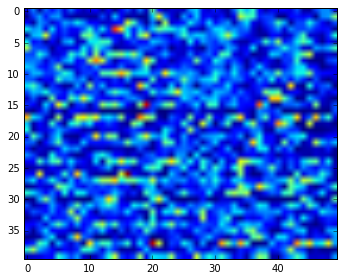

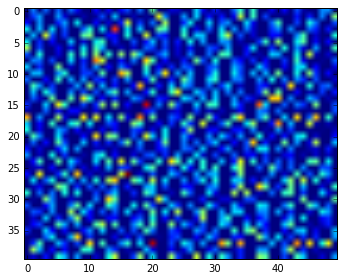

In [359]:
plt.figure()
plt.imshow(np.squeeze(fmaps2[1]))
plt.figure()
plt.imshow(np.squeeze(fmap2[1]))

## verify inverse function

In [360]:
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f54487e51d0>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5435e05890>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7f54487c4b50>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f5435e12d90>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f5435e05a50>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5435e05a90>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7f5435e05ad0>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f5435e24050>,
 'dense1': <lasagne.layers.dense.DenseLayer at 0x7f5435e24090>,
 'dense1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f5435e24510>,
 'dense1_bias': <lasagne.layers.special.BiasLayer at 0x7f54ac6636d0>,
 'input': <lasagne.layers.input.InputLayer at 0x7f54487e5150>,
 'output': <lasagne.layers.special.NonlinearityLayer at 0x7f5435e24810>,
 'output_bias': <lasagne.layers.special.BiasLayer at 0x7f5435e246d0>}

In [361]:
active = theano.function([nnmodel.input_var], layers.get_output(network['conv1_active']), allow_input_downcast=True)
bias = theano.function([nnmodel.input_var], layers.get_output(network['conv1_bias']), allow_input_downcast=True)
conv = theano.function([nnmodel.input_var], layers.get_output(network['conv1']), allow_input_downcast=True)

X = train[0][map_index]
a = np.squeeze(active(X))
b = np.squeeze(bias(X))
c = np.squeeze(conv(X))

In [362]:
## verify inverse operation

# active a[0]
# bias b[0]
# convolution c[0]


a2 = np.log(np.exp(a[0])-1)
print float(np.sum((a2-b[0])**2 < .00001)) / np.prod(list(a2.shape))


1.0


In [363]:
# verify bias

b1 = network['conv1_bias'].b.get_value()
b2 = a2 - np.outer(b1,np.ones(200))
print float(np.sum((b2-c[0])**2 < .00001)) / np.prod(list(a2.shape))

1.0


In [364]:
tmp = np.expand_dims(b2, 0)
tmp = np.expand_dims(tmp,3)
tmp.shape

(1, 20, 200, 1)

In [263]:
def pseudoinverse_filter(W1):
    weight = np.squeeze(W1)

    W1_inv = []
    for i in range(len(weight)):
        W1_inv.append(np.linalg.pinv(weight[i]))
    W1_inv = np.array(W1_inv, dtype=theano.config.floatX)
    W1_inv = np.expand_dims(W1_inv,3).transpose([2,0,1,3])
    W1_inv = theano.shared(W1_inv)
    return W1_inv

# verify inverse convolution
W1 = network['conv1'].W.get_value()
W1_inv = pseudoinverse_filter(W1)

In [283]:
W1.shape

(20, 4, 15, 1)

In [365]:
def pseudoinverse_filter2(W1):
    #W1 = W1.transpose([1,0,2,3])
    weight = np.squeeze(W1)    
    W1_inv = []
    for i in range(len(weight)):
        W1_inv.append(np.linalg.pinv(weight[i]))
    W1_inv = np.array(W1_inv, dtype=theano.config.floatX)
    W1_inv = np.expand_dims(W1_inv,3).transpose([2,0,1,3])
    W1_inv = theano.shared(W1_inv)
    return W1_inv

# verify inverse convolution
W1 = network['conv1'].W.get_value()
W1_inv = pseudoinverse_filter2(W1)

In [469]:
w = np.squeeze(W1)
x = np.squeeze(X[3])
x = x[:,range(50,65)]
val = []
for i in range(len(w)):
    val.append(np.sum(x * w[i]))
val = np.array(val)

In [513]:
w2 = []
for i in range(len(w)):
    w2.append(np.linalg.pinv(w[i]))
w2 = np.array(w2)

val2 = []
for i in range(len(w2)):
    val2.append(np.dot(w2[i],val))
val2 = np.array(val2)

In [523]:
w2.shape

(4, 15, 20)

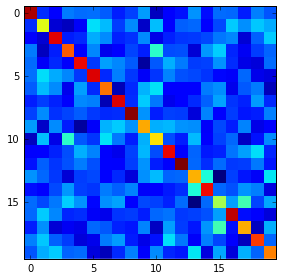

In [524]:
plt.imshow(np.dot(w[0],w2[0]), interpolation='none')

In [516]:
x.T

array([[ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]], dtype=float32)

In [525]:
def pseudoinverse_filter2(W1):
    #W1 = W1.transpose([2,0,1,3])
    weight = np.squeeze(W1)    
    W1_inv = []
    for i in range(len(weight)):
        W1_inv.append(np.linalg.pinv(weight[i]))
    W1_inv = np.array(W1_inv, dtype=theano.config.floatX)
    W1_inv = np.expand_dims(W1_inv,3).transpose([2,0,1,3])
    W1_inv = theano.shared(W1_inv)
    return W1_inv

W1_inv = pseudoinverse_filter2(W1)
w = W1_inv.get_value()
w = np.squeeze(w)
w.shape

(4, 20, 15)

In [576]:
shape2 = (None, 20, 200, 1)
input_var2 = T.tensor4('fmap')
input2 = InputLayer(shape2, input_var=input_var2)
deconv1 = Conv2DLayer(input2, num_filters=4,
                                      filter_size=(15,1),
                                      W=network['conv1'].W.transpose([1,0,2,3]), #W1_inv, #  network['conv1'].W.transpose([1,0,2,3]), #
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
prediction = get_output(deconv1)
reconstruction = theano.function([input_var2], prediction, allow_input_downcast=True)



In [577]:
#c = np.expand_dims(c,3)
X2 = reconstruction(c.astype(np.float32))
X2 = np.array(X2)

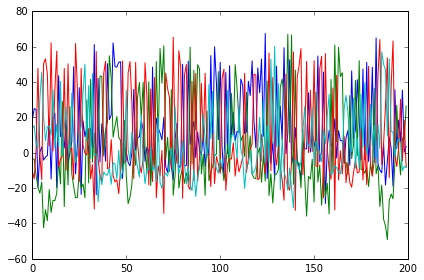

In [578]:
plt.figure()
plt.plot(np.squeeze(X2[70].T));

In [580]:
X = train[0]

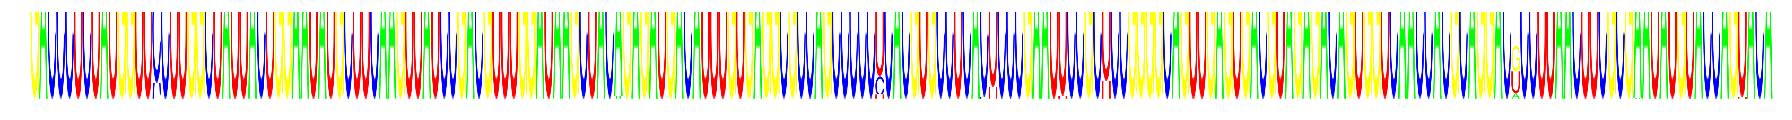

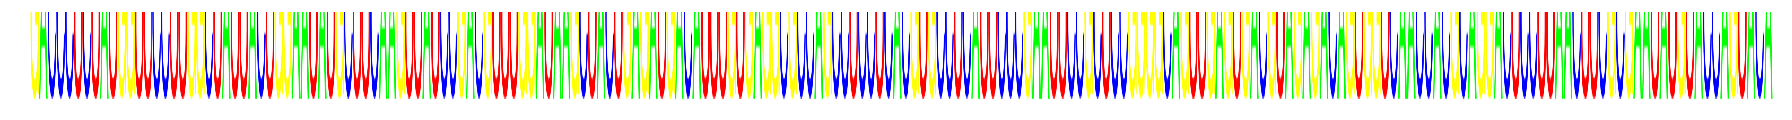

In [605]:
index = 77
pwm = np.squeeze(X2[index])
pwm2 = np.squeeze(X[index])

height=300
bp_width=30
num_seq = pwm.shape[1]
width = bp_width*num_seq
size = (25.,25.0)

MAX = np.max(pwm,axis=0)
maxX = np.exp(pwm-MAX)
sumX = np.sum(maxX,axis=0)
normX = maxX/np.outer(np.ones(4),sumX)

logo = seq_logo(normX, height, width, norm=0, rna=1, filepath='.')

fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');

logo = seq_logo(pwm2, height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');


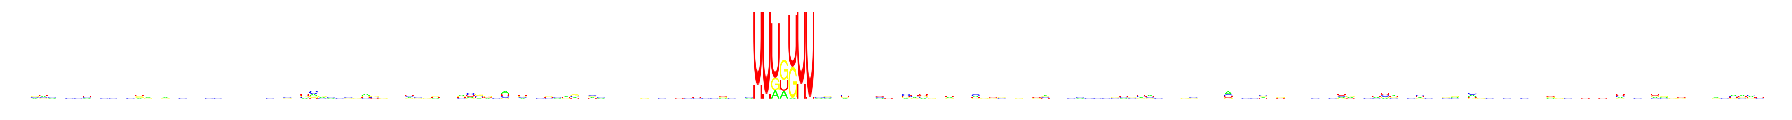

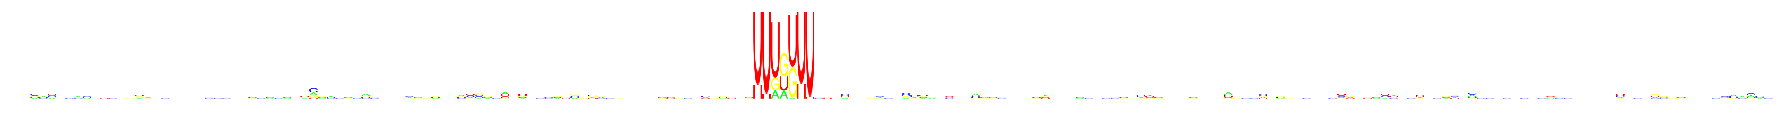

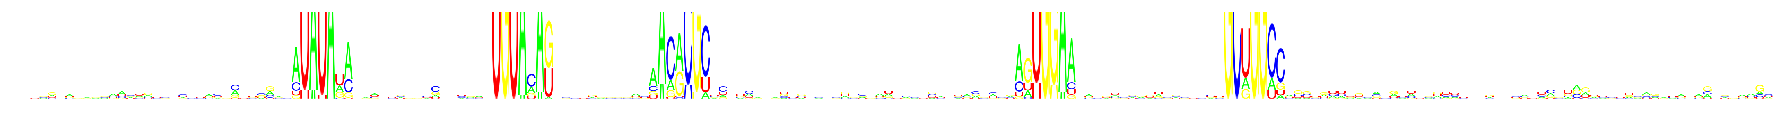

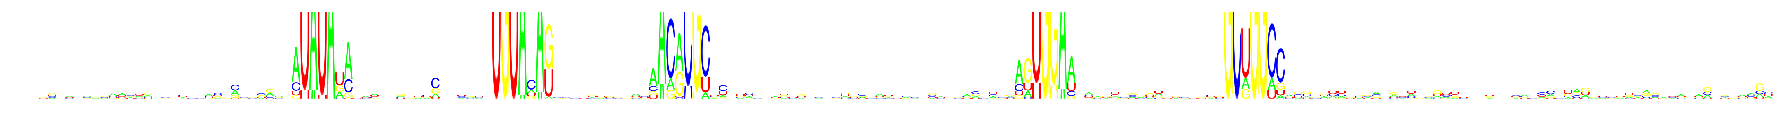

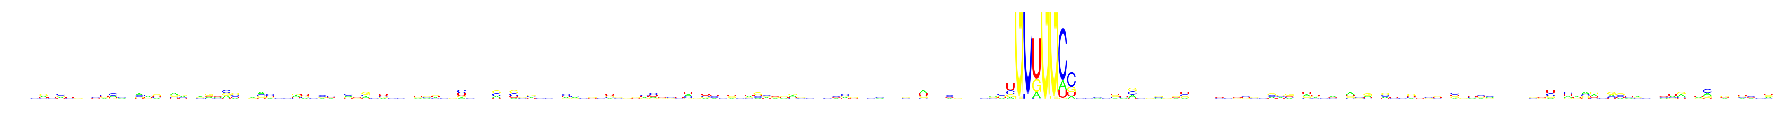

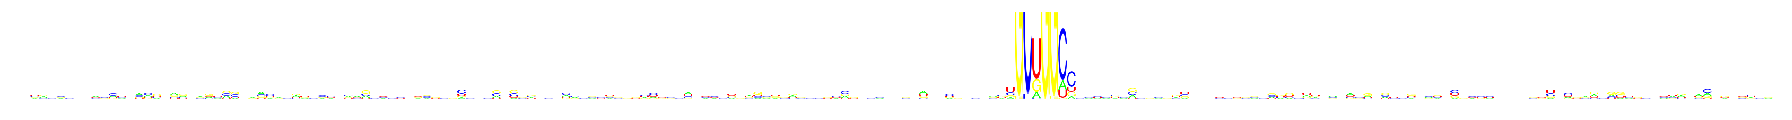

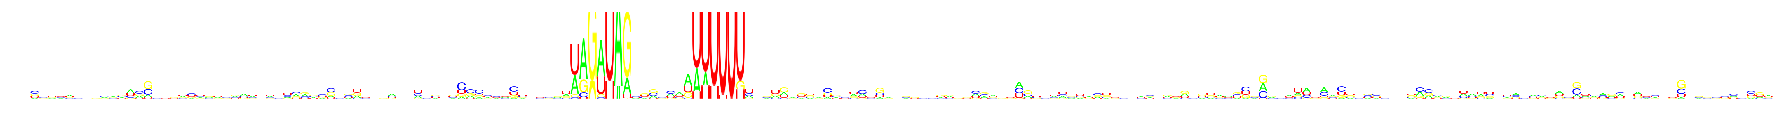

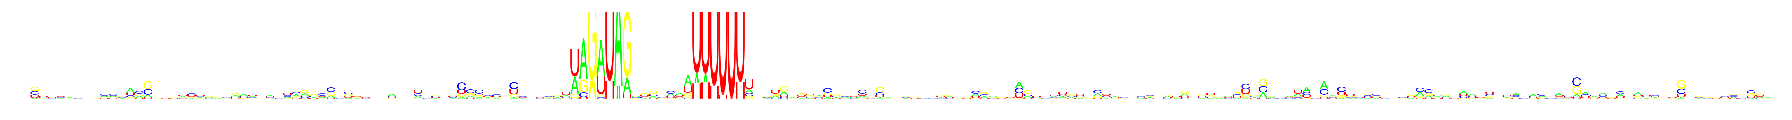

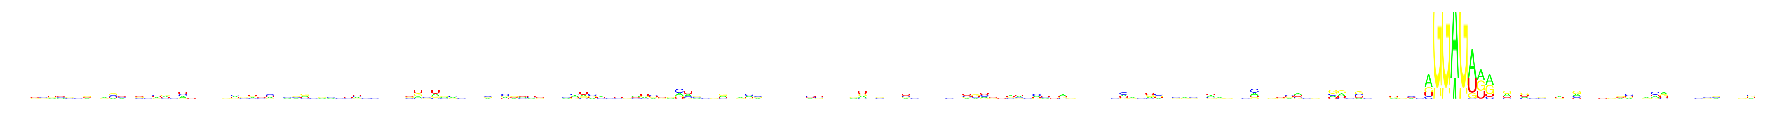

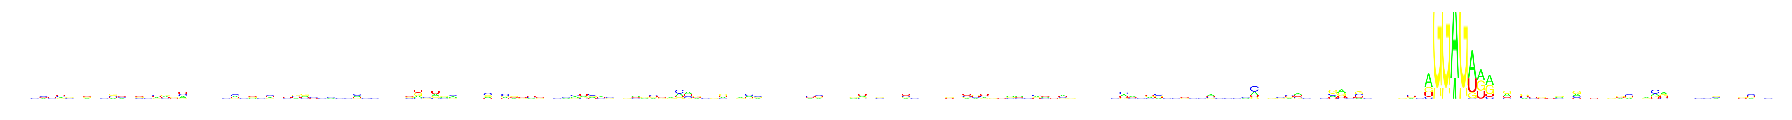

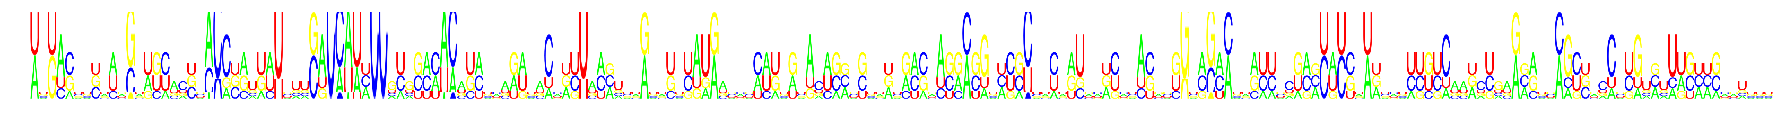

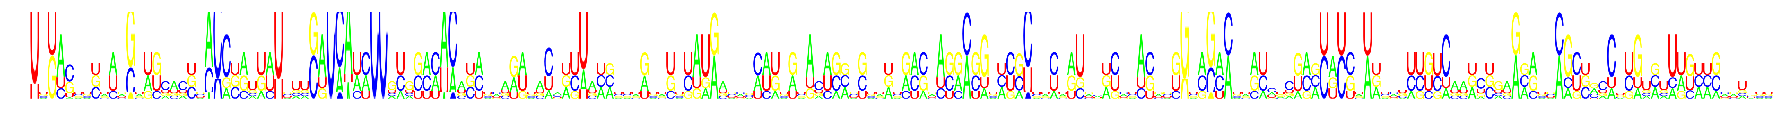

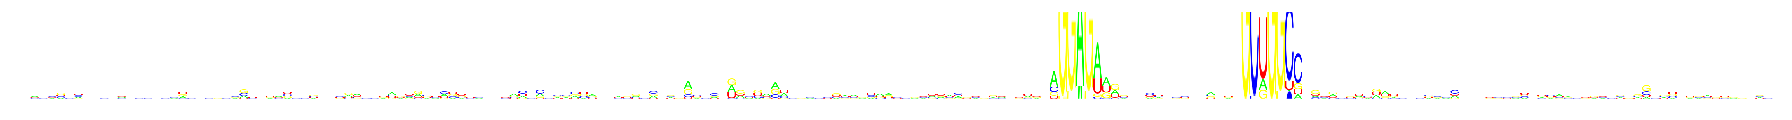

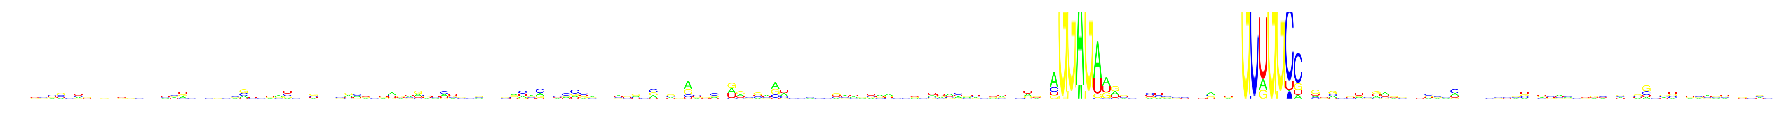

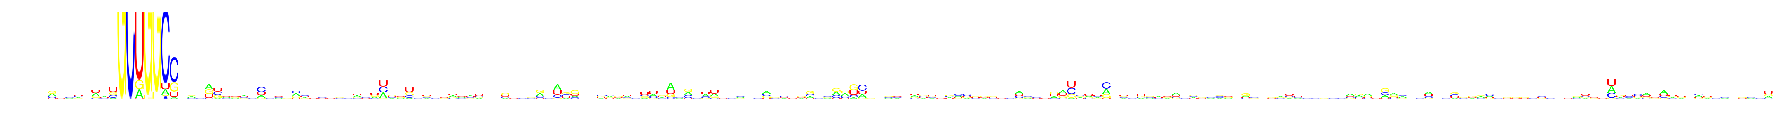

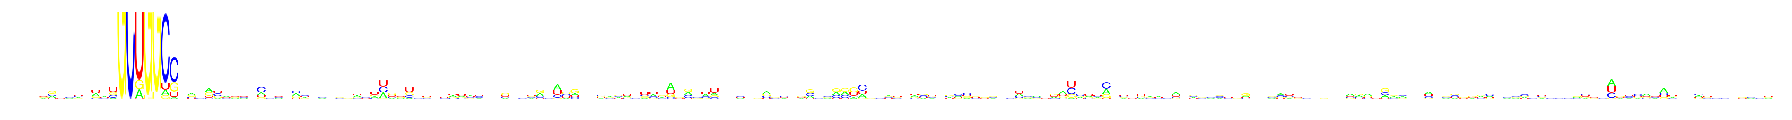

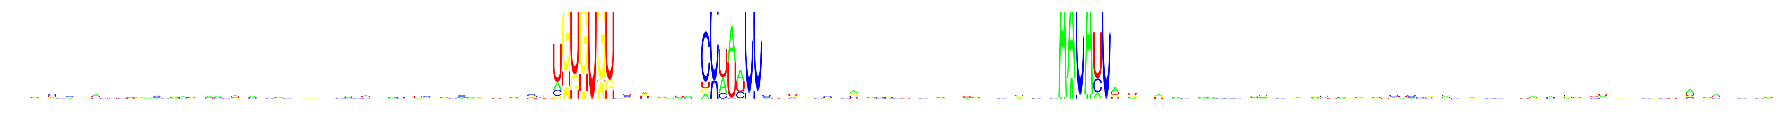

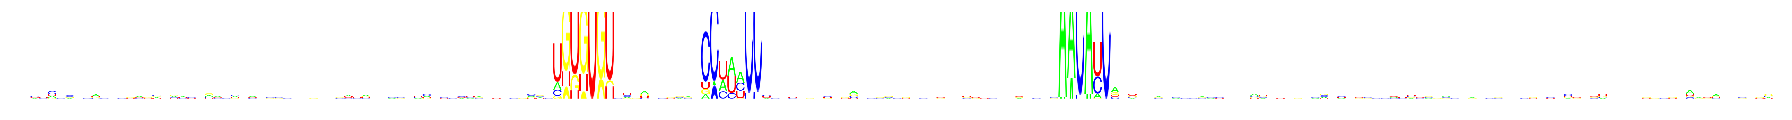

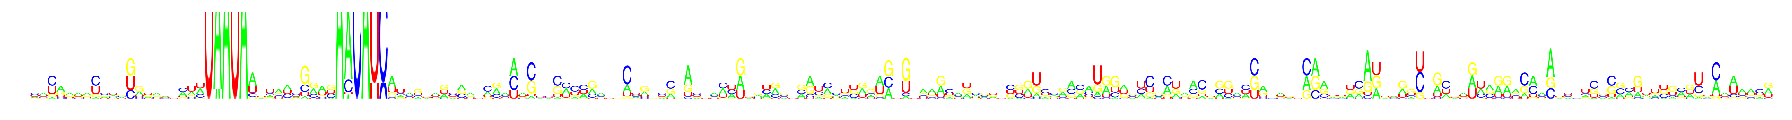

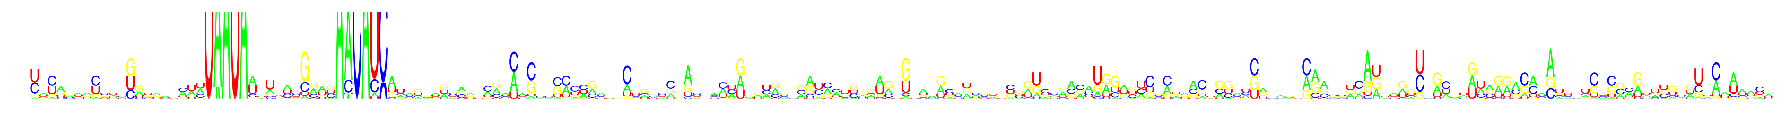

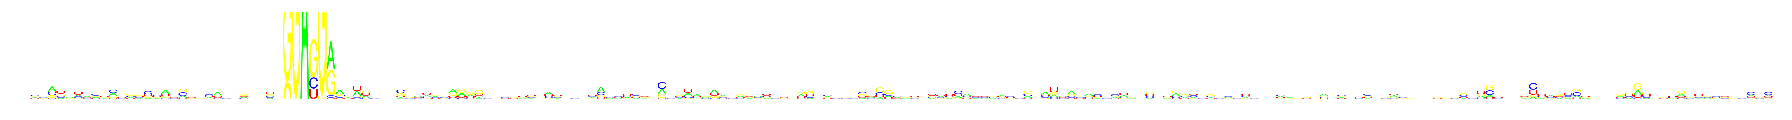

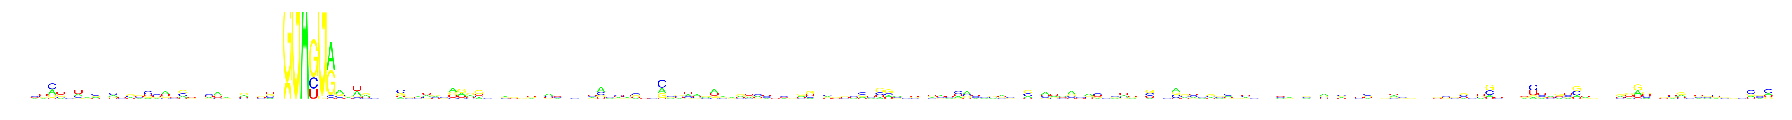

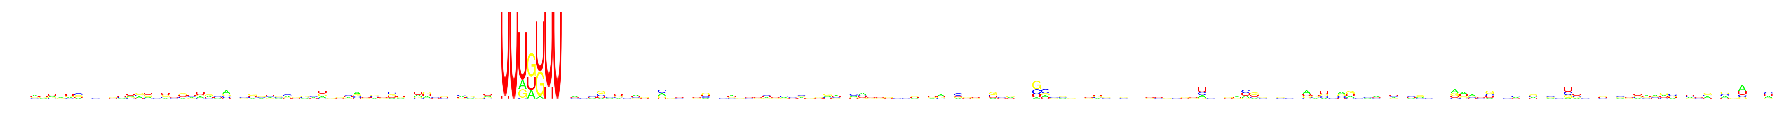

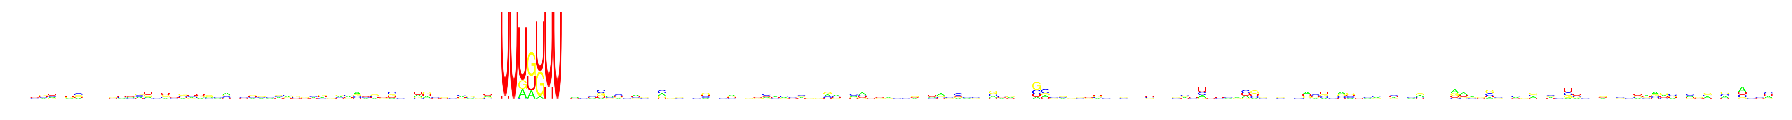

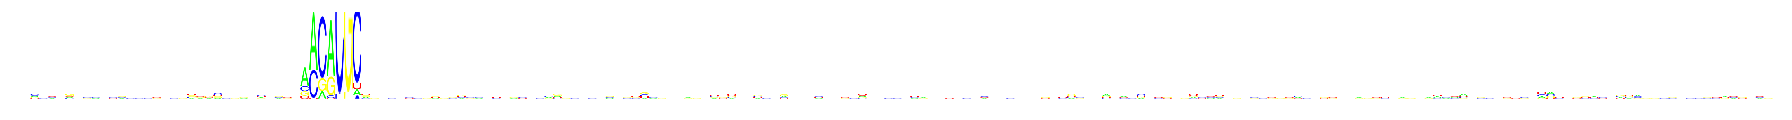

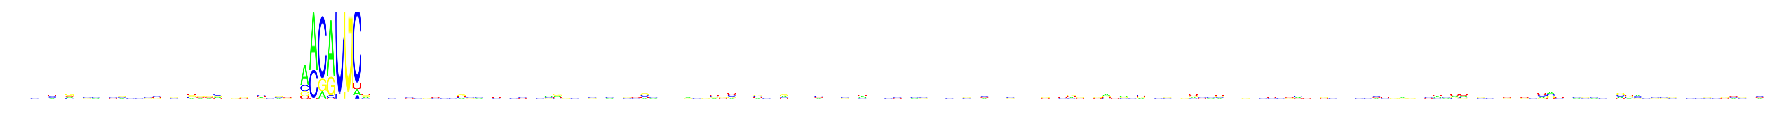

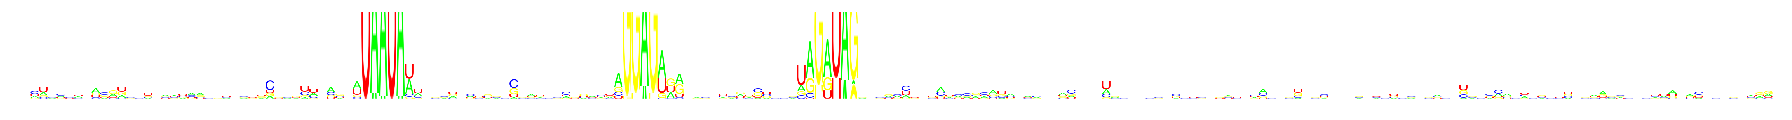

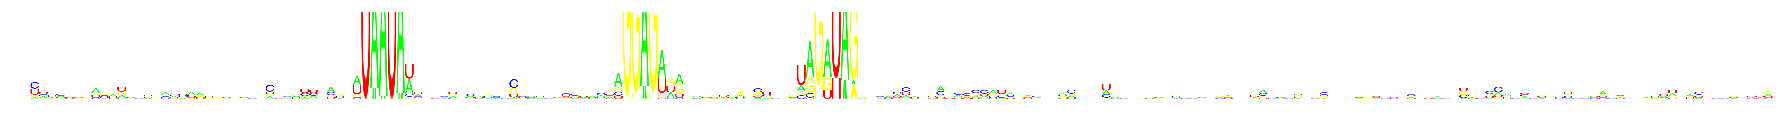

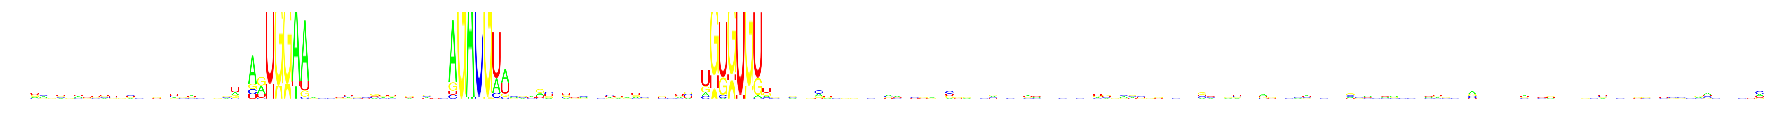

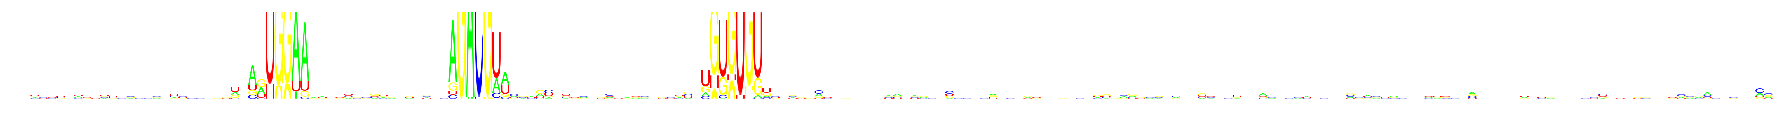

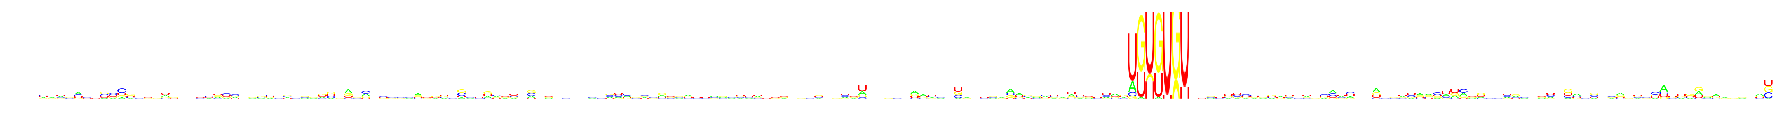

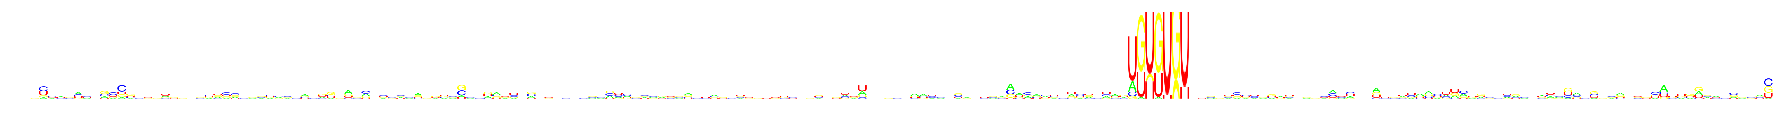

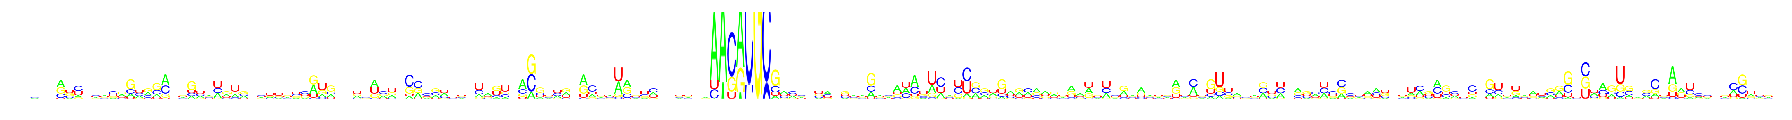

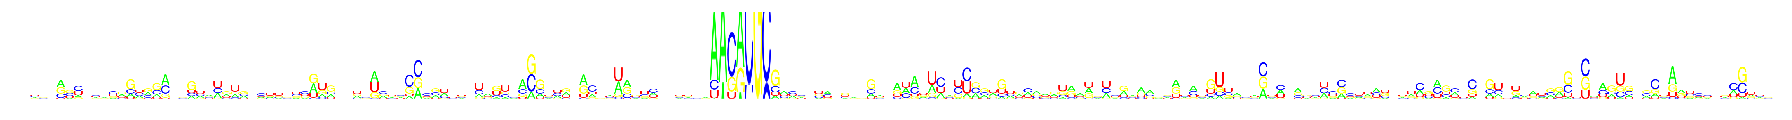

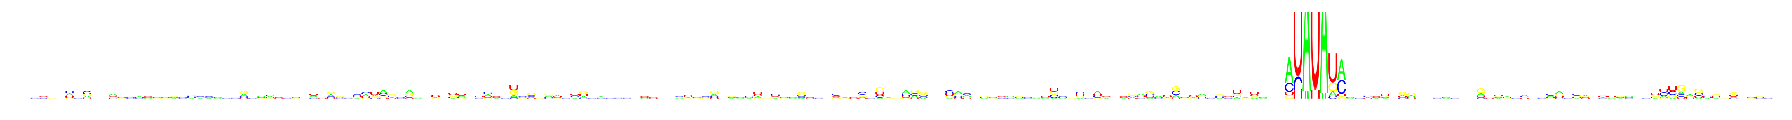

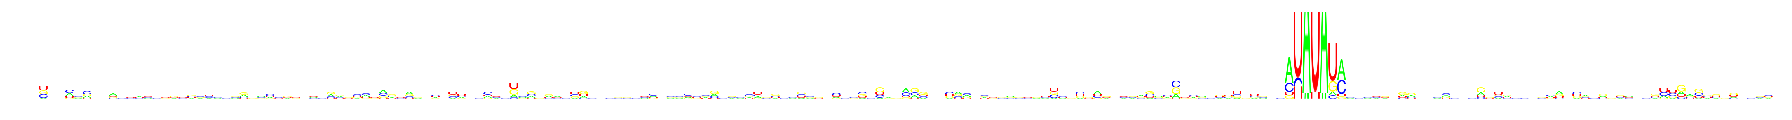

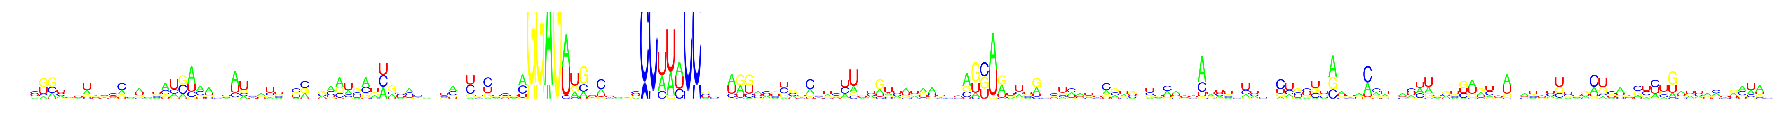

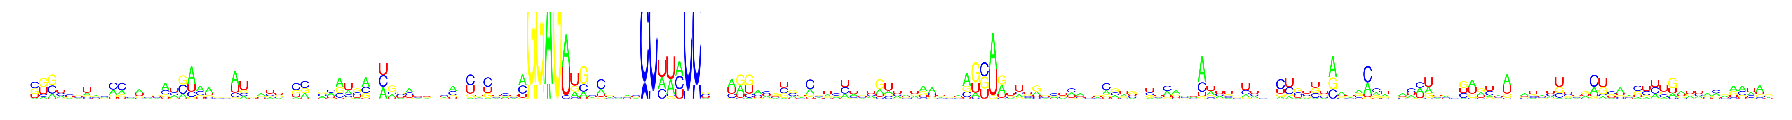

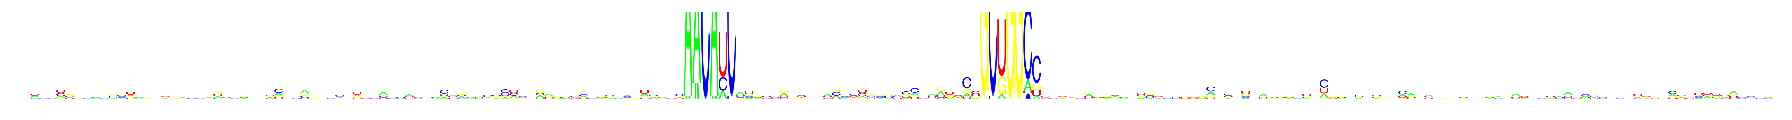

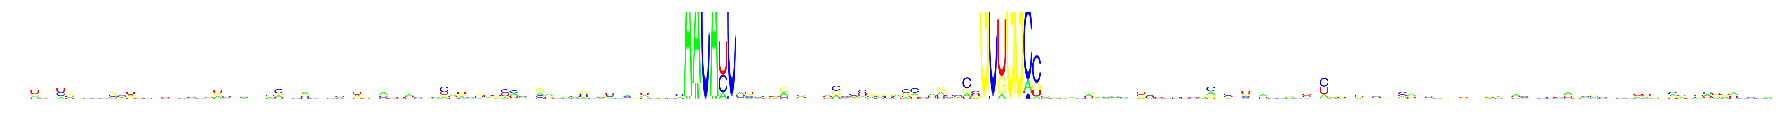

In [606]:
def get_class_pwm(X, class_index, norm=0):
    class_pwm = 0
    for i in class_index:
        x = X[i]
        if norm == 1:
            MEAN = np.nanmean(x,axis=1)
            x -= np.outer(MEAN, np.ones(x.shape[1]))
            #STD = np.nanstd(x,axis=1)
            #x /= np.outer(STD, np.ones(x.shape[1]))
            x -= np.max(x, axis=0)
            x = np.exp(x)
            sumX = np.sum(x,axis=0)
            x /= np.outer(np.ones(4),sumX)
        class_pwm += x
    class_pwm /= len(class_index)
    return class_pwm


for class_plot in range(20):
    y = np.argmax(train[1], axis=1)
    y = y[map_index]
    class_index = np.where(y == class_plot)[0]
    class_pwm = get_class_pwm(np.squeeze(X), class_index)
    logo = seq_logo(class_pwm, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');

    class_pwm = get_class_pwm(np.squeeze(X2), class_index, norm=1)
    logo = seq_logo(class_pwm, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');


In [793]:
W3.shape

(1000, 200)

In [824]:
#X2, labels = reconstruct_layer2(network, train)
map_index = range(10000)
X = train[0][map_index]
y = train[1][map_index]


# psuedo-inverse filters
W3 = network['dense1'].W.get_value()
b3 = network['dense1_bias'].b.get_value()
dense1 = get_feature_maps(network['dense1_active'], nnmodel.input_var, X)

bias3 = dense1-np.outer(np.ones(dense1.shape[0]),b3)
inv3 = np.log(np.exp(bias3))
active3 = np.dot(inv3,W3.T) 


(1000, 200)

In [827]:
active = get_feature_maps(network['conv2_active'], nnmodel.input_var, X)
active.shape

(10000, 40, 50, 1)

In [738]:

# psuedo-inverse filters
W1 = network['conv1'].W.get_value()
W2 = network['conv2'].W.get_value()
W1_inv = pseudoinverse_filter2(W1)
W2_inv = pseudoinverse_filter2(W2)

# max-unpool layer 2
active = get_feature_maps(network['conv2_active'], nnmodel.input_var, X)
pool = get_feature_maps(network['conv2_pool'], nnmodel.input_var, X)

fmap2 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap2.append(fmap_unpool)

fmap2 = np.array(fmap2)
fmap2 = np.expand_dims(fmap2, 3)


# deconvolution layer 2
input_var2 = T.tensor4('fmap')
shape2 = list(fmap2.shape)
shape2[0] = None
input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
unpool2 = ExpressionLayer(input2, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool2 = BiasLayer(unpool2, b=-network['conv2_bias'].b)
deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                      filter_size=network['conv2'].filter_size,
                                      W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
prediction = get_output(deconv2)
prediction = theano.function([input_var2], prediction, allow_input_downcast=True)
intermediate = prediction(fmap2.astype(np.float32))


In [744]:
intermediate= np.array(intermediate)
for i in range(len(intermediate)):
    x = np.squeeze(intermediate[i])
    MEAN = np.mean(intermediate[i], axis=1)
    x -= np.outer(MEAN, np.ones(x.shape[1]))
    x -= np.max(x, axis=0)
    x = np.exp(x)
    sumX = np.sum(x,axis=0)
    x /= np.outer(np.ones(x.shape[0]),sumX)
    intermediate[i] = np.expand_dims(x,2)
    

In [745]:

# max-unpool layer 1
active = get_feature_maps(network['conv1_active'], nnmodel.input_var, train[0][map_index])
pool = intermediate

print active.shape
print pool.shape

(10000, 20, 200, 1)
(10000, 20, 50, 1)


In [746]:

pool_size = active.shape[2]/pool.shape[2]
fmap1 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap1.append(fmap_unpool)

fmap1 = np.array(fmap1)
fmap1 = np.expand_dims(fmap1, 3)


In [747]:


# deconvolution layer 1
input_var1 = T.tensor4('fmap')
shape1 = list(fmap1.shape)
shape1[0] = None
input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                      filter_size=network['conv1'].filter_size,
                                      W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv, # 
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)

prediction = get_output(deconv1)
reconstruction = theano.function([input_var1], prediction, allow_input_downcast=True)
X2 = np.squeeze(reconstruction(fmap1.astype(np.float32)))

4


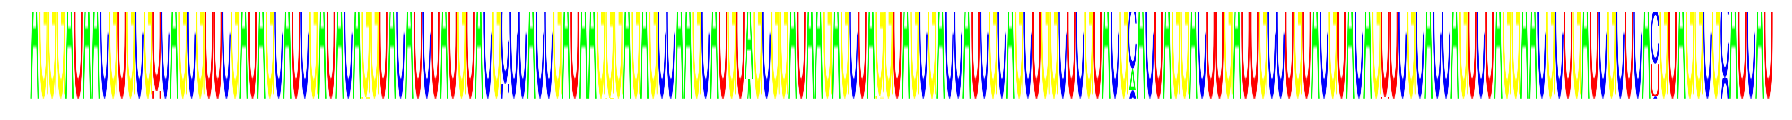

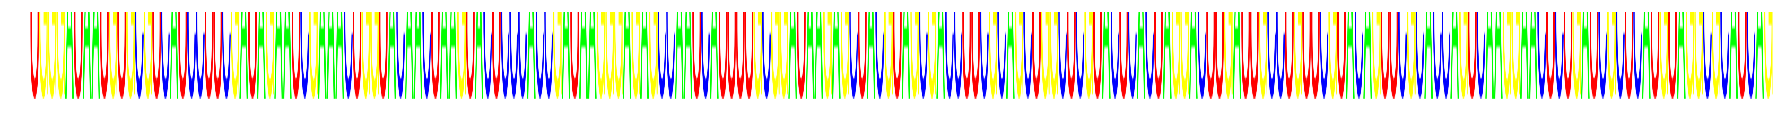

In [748]:
index = 3
x = np.squeeze(X2[index])
print np.argmax(X[index])

height=300
bp_width=30
num_seq = X2.shape[2]
width = bp_width*num_seq
size = (25.,25.0)

MEAN = np.nanmean(x,axis=1)
x -= np.outer(MEAN, np.ones(x.shape[1]))
x -= np.max(x, axis=0)
x = np.exp(x)
sumX = np.sum(x,axis=0)
x /= np.outer(np.ones(4),sumX)
logo = seq_logo(x, height, width, norm=0, rna=1, filepath='.')

fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');

logo = seq_logo(np.squeeze(train[0][map_index[index]]), height, width, norm=0, rna=1, filepath='.')
fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');


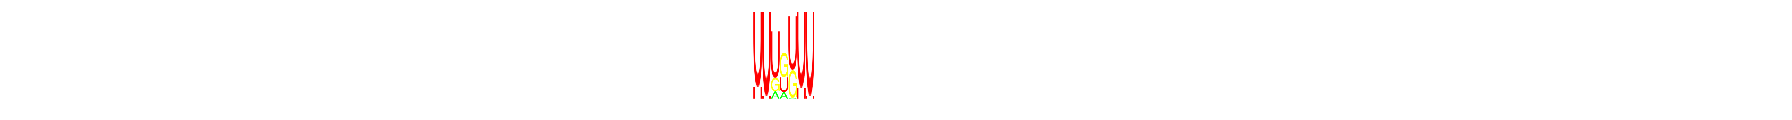

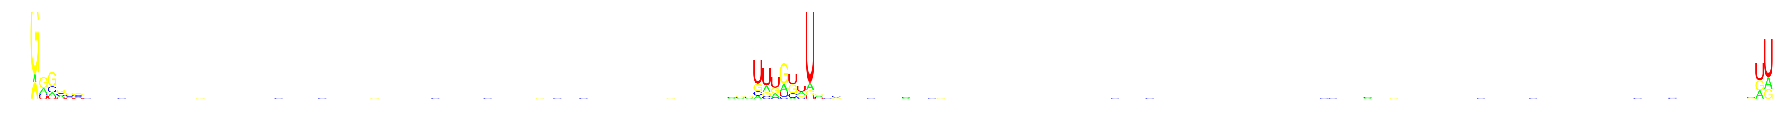

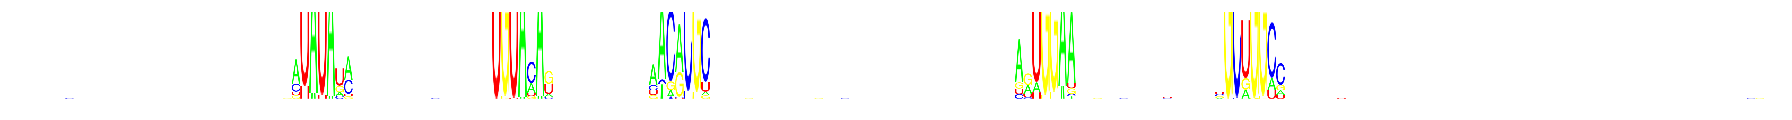

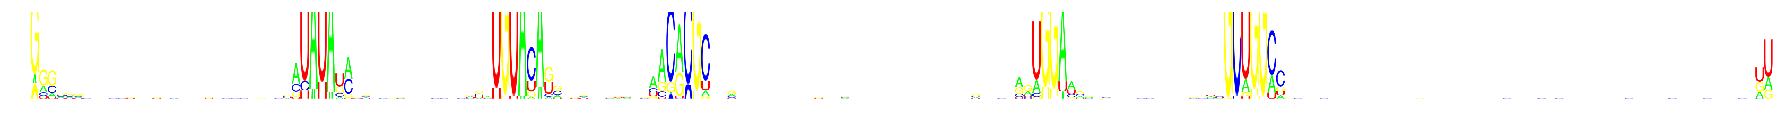

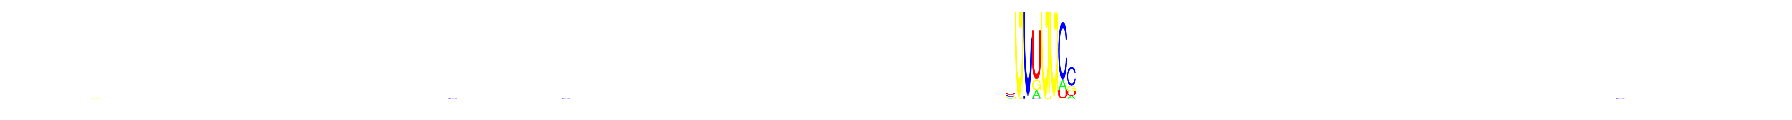

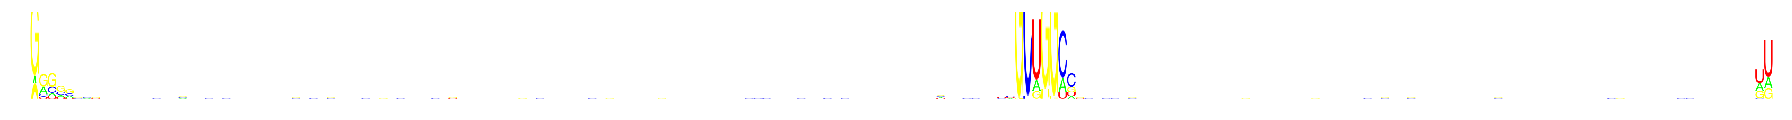

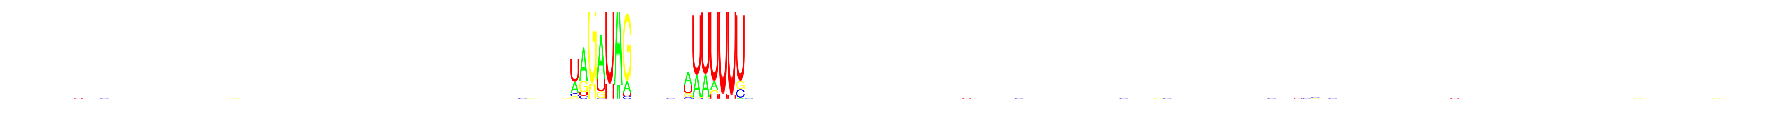

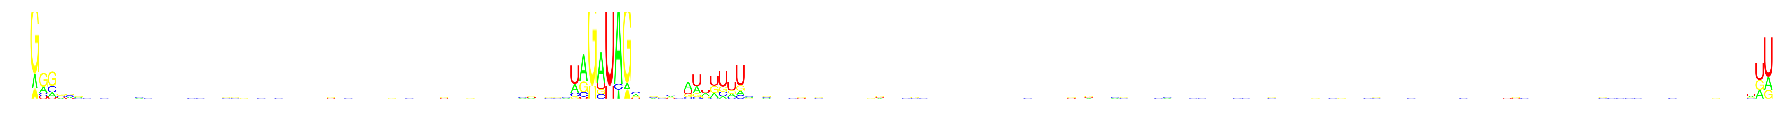

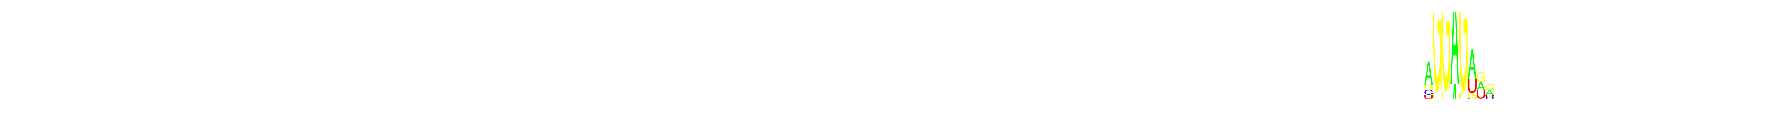

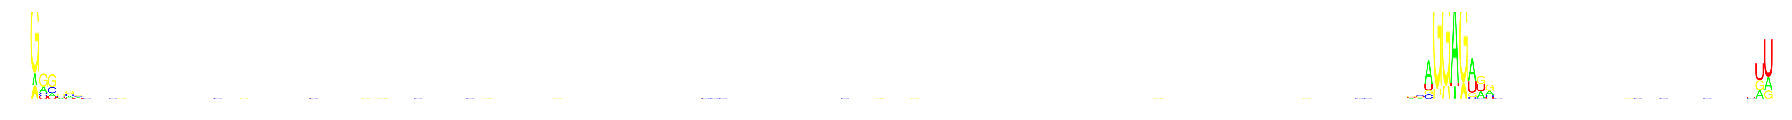

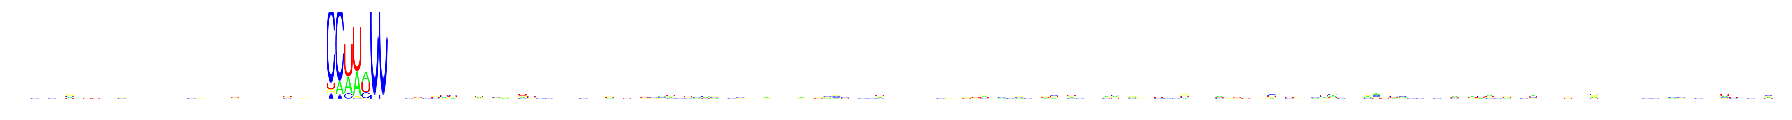

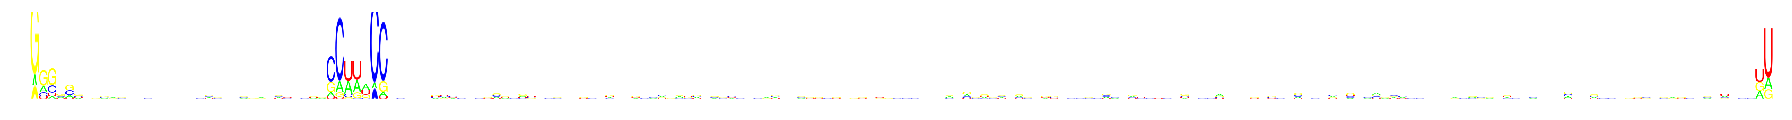

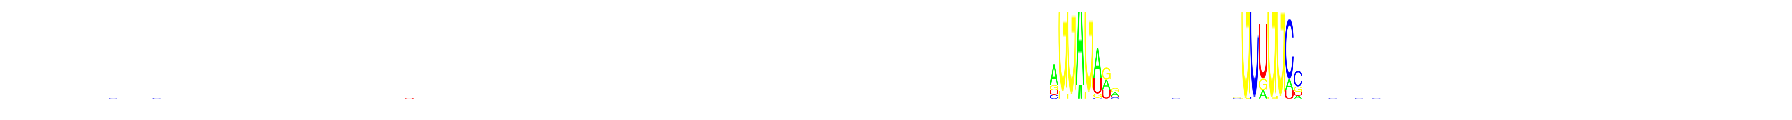

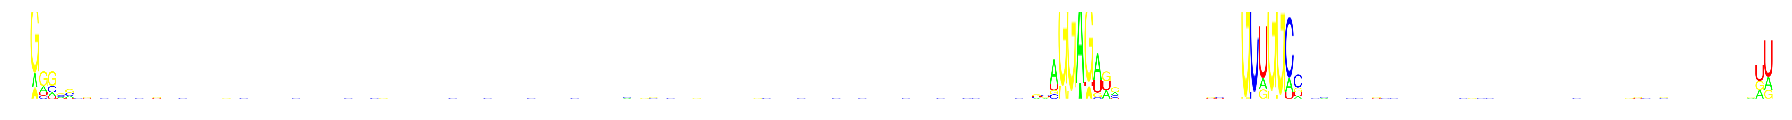

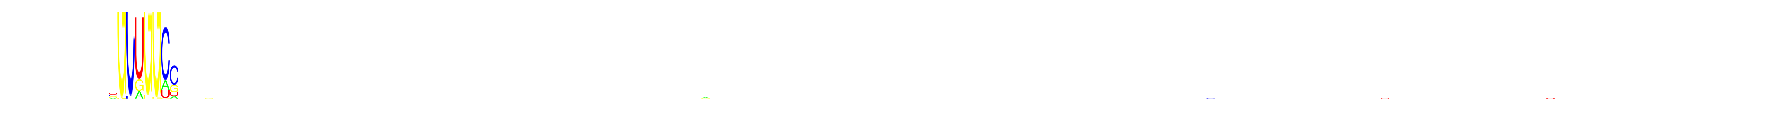

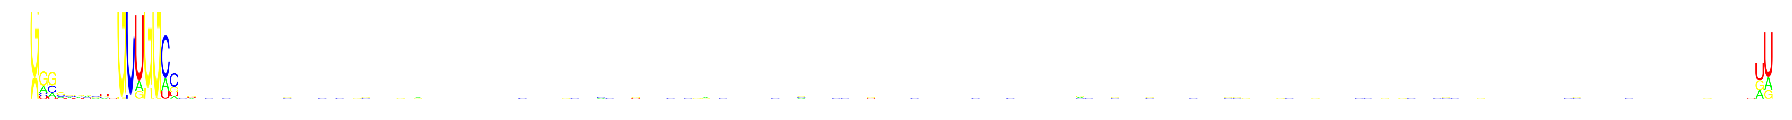

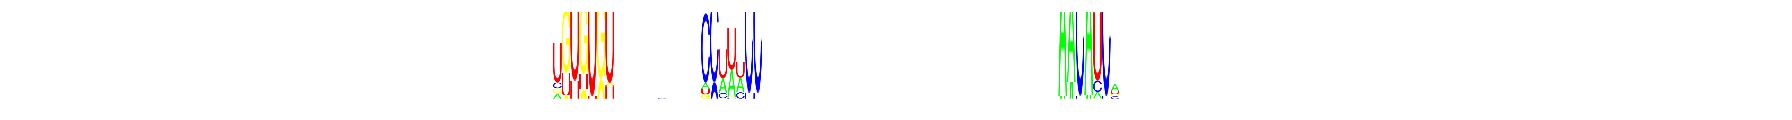

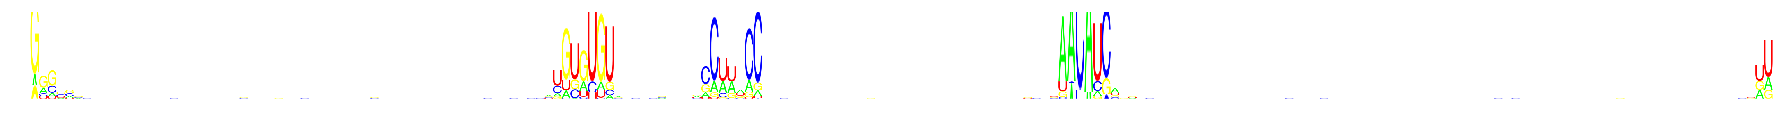

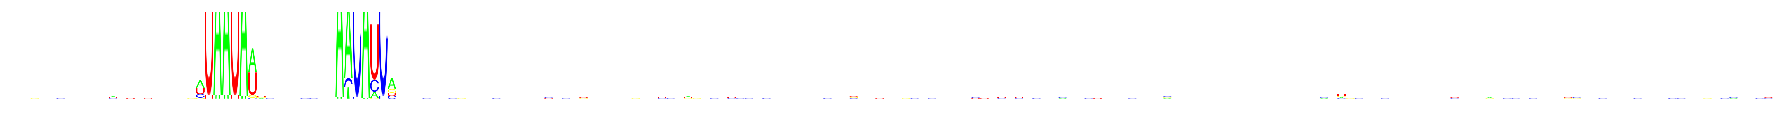

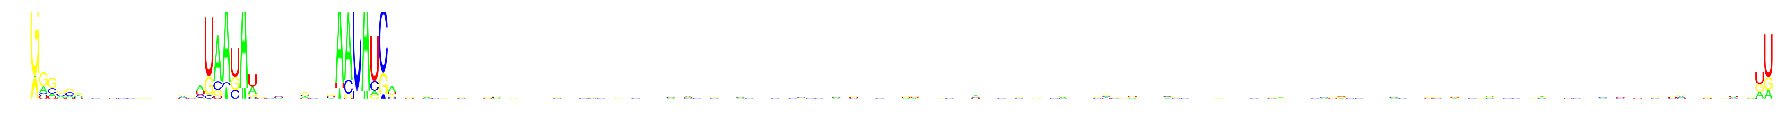

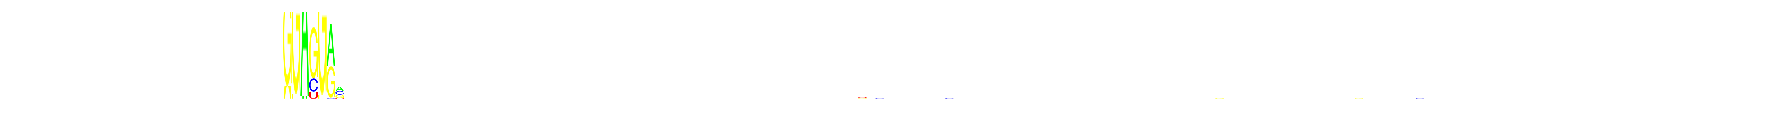

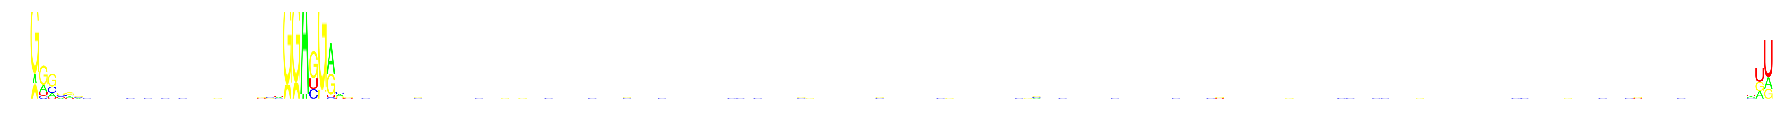

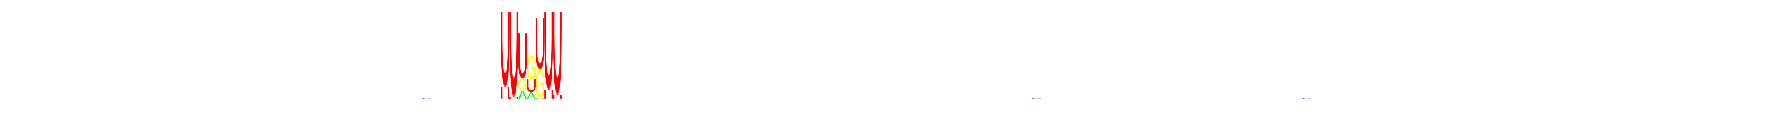

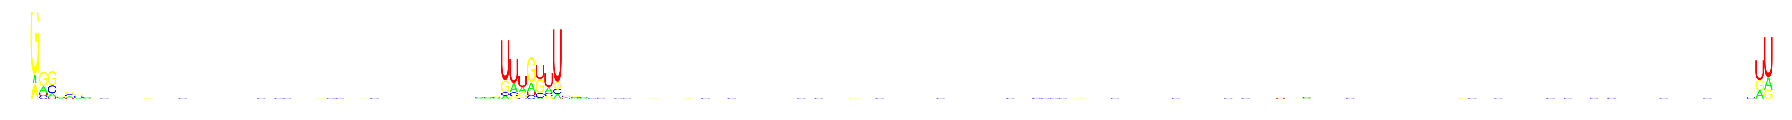

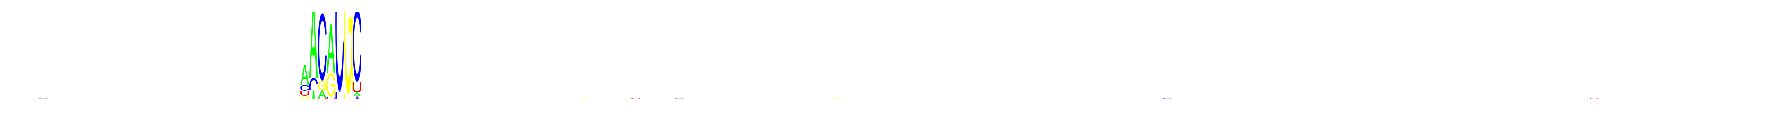

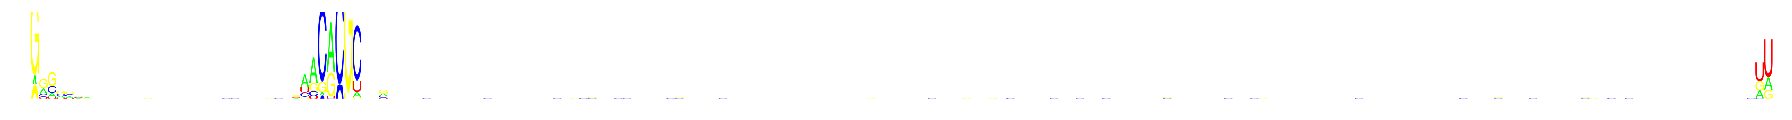

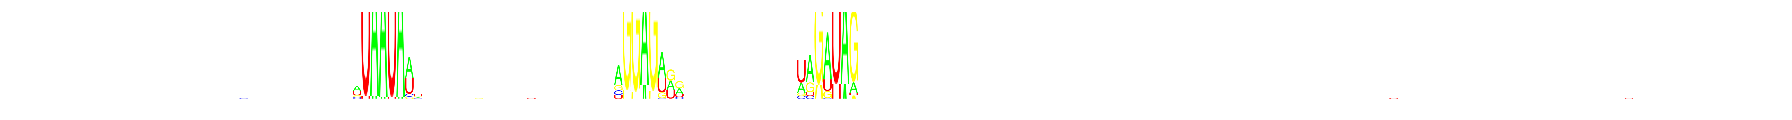

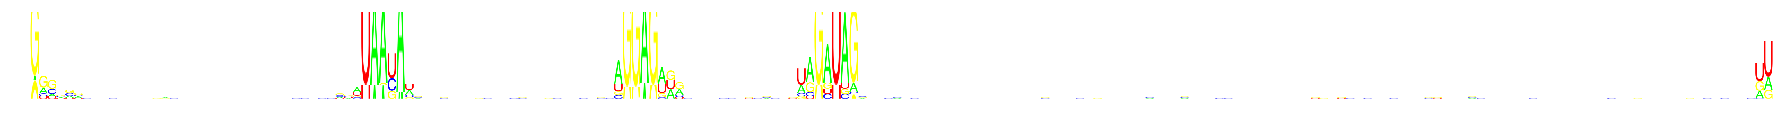

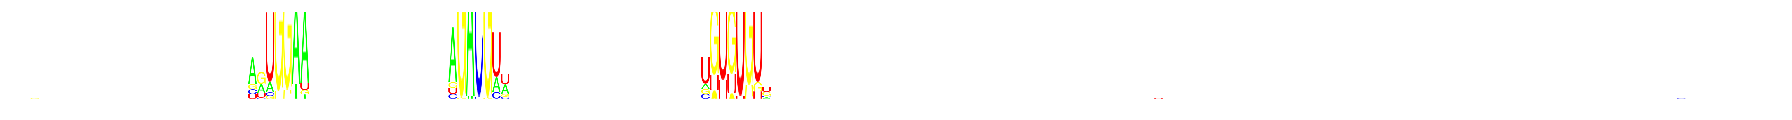

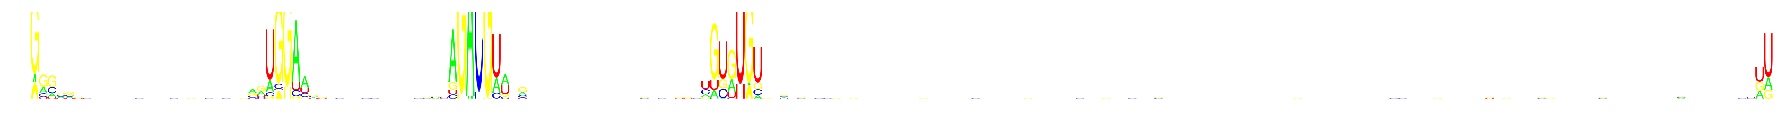

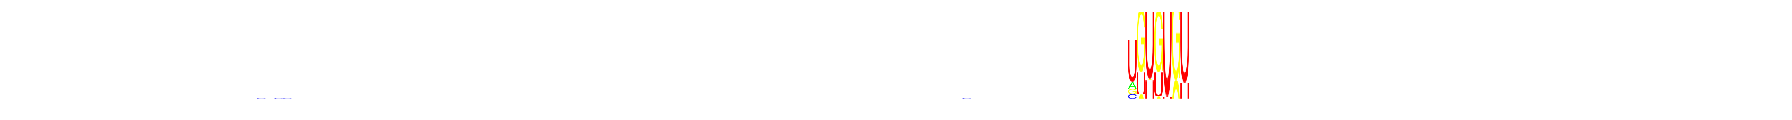

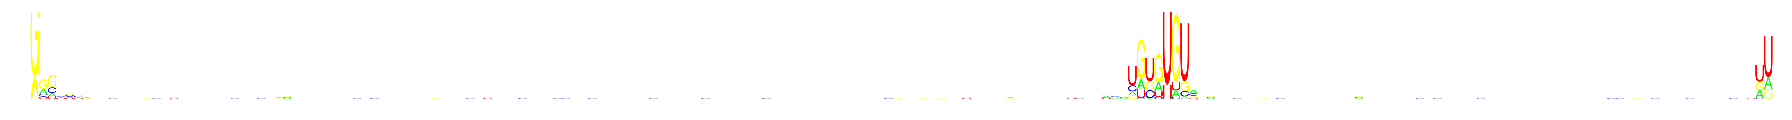

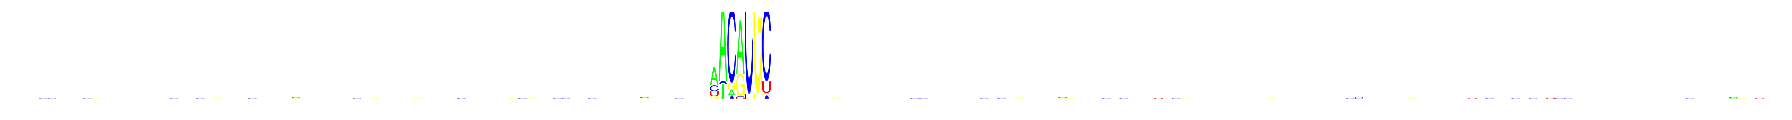

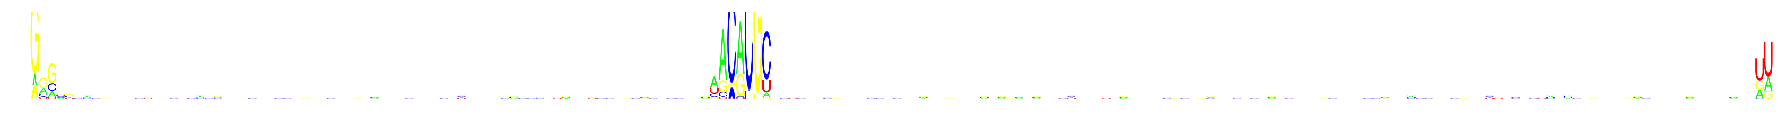

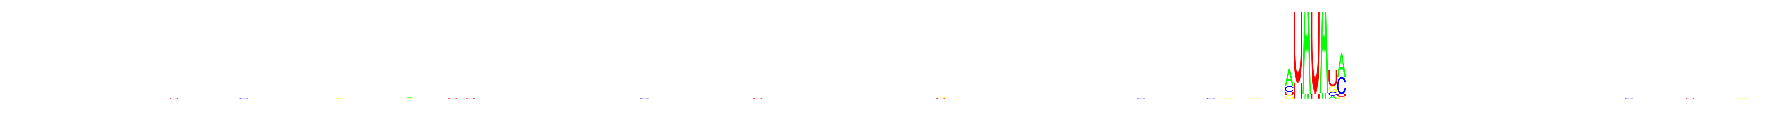

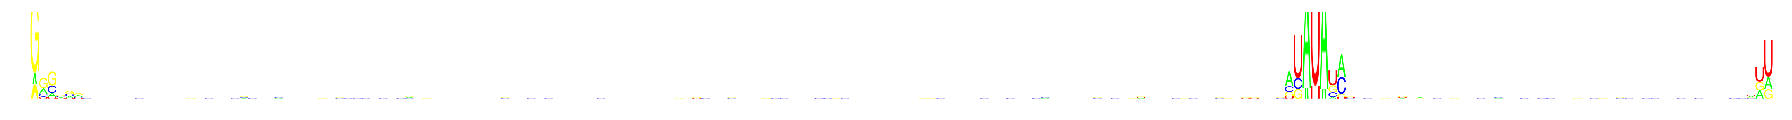

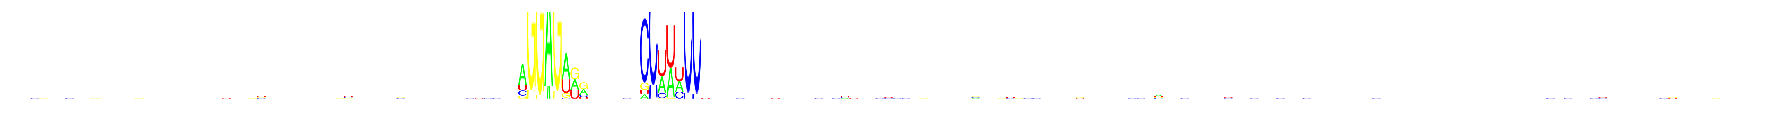

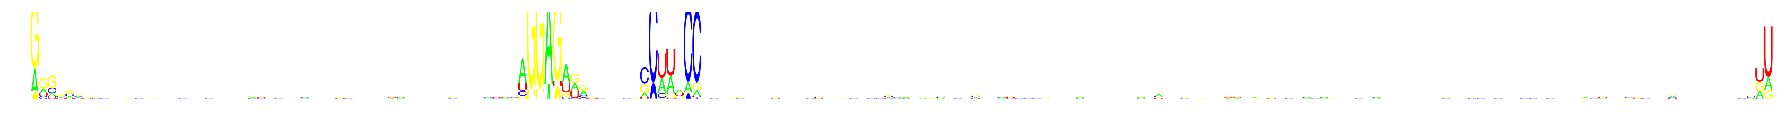

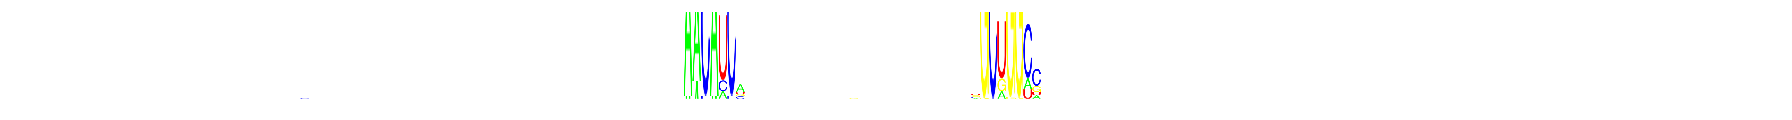

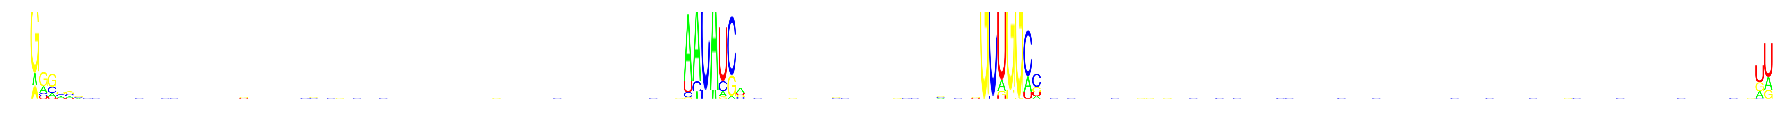

In [749]:
def get_class_pwm(X, class_index, norm=0):
    class_pwm = 0
    for i in class_index:
        x = X[i]
        if norm == 1:
            MEAN = np.nanmean(x,axis=1)
            x -= np.outer(MEAN, np.ones(x.shape[1]))
            #STD = np.nanstd(x,axis=1)
            #x /= np.outer(STD, np.ones(x.shape[1]))
            x -= np.max(x, axis=0)
            x = np.exp(x)
            sumX = np.sum(x,axis=0)
            x /= np.outer(np.ones(4),sumX)
        class_pwm += x
    class_pwm /= len(class_index)
    return class_pwm


X = train[0][map_index]
for class_plot in range(20):
    y = np.argmax(train[1], axis=1)
    y = y[map_index]
    class_index = np.where(y == class_plot)[0]
    class_pwm = get_class_pwm(np.squeeze(X), class_index)
    logo = seq_logo(class_pwm, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');

    class_pwm = get_class_pwm(np.squeeze(X2), class_index, norm=1)
    logo = seq_logo(class_pwm, height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size)
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');

In [776]:
#X2, labels = reconstruct_layer2(network, train)
map_index = range(100)
X = train[0][map_index]
y = train[1][map_index]

# psuedo-inverse filters
W1 = network['conv1'].W.get_value()
W2 = network['conv2'].W.get_value()
W1_inv = pseudoinverse_filter2(W1)
W2_inv = pseudoinverse_filter2(W2)

# max-unpool layer 2
active2 = get_feature_maps(network['conv2_active'], nnmodel.input_var, X)
pool2 = get_feature_maps(network['conv2_pool'], nnmodel.input_var, X)

pool_size = active2.shape[2]/pool2.shape[2]
fmap2 = []
for k in range(active2.shape[0]):
    x = np.squeeze(active2[k])
    mymap = np.squeeze(pool2[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap2.append(fmap_unpool)

fmap2 = np.array(fmap2)
fmap2 = np.expand_dims(fmap2, 3)


# deconvolution layer 2
input_var2 = T.tensor4('fmap')
shape2 = list(fmap2.shape)
shape2[0] = None
input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
unpool2 = ExpressionLayer(input2, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool2 = BiasLayer(unpool2, b=-network['conv2_bias'].b)
deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                      filter_size=network['conv2'].filter_size,
                                      W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
prediction = get_output(deconv2)
prediction = theano.function([input_var2], prediction, allow_input_downcast=True)
intermediate = prediction(fmap2.astype(np.float32))


intermediate= np.array(intermediate)
for i in range(len(intermediate)):
    x = np.squeeze(intermediate[i])
    MEAN = np.mean(intermediate[i], axis=1)
    x -= np.outer(MEAN, np.ones(x.shape[1]))
    x -= np.max(x, axis=0)
    x = np.exp(x)
    sumX = np.sum(x,axis=0)
    x /= np.outer(np.ones(x.shape[0]),sumX)
    intermediate[i] = np.expand_dims(x,2)
    
# max-unpool layer 1
active = get_feature_maps(network['conv1_active'], nnmodel.input_var, X)
pool = intermediate


pool_size = active.shape[2]/pool.shape[2]
fmap1 = []
for k in range(active.shape[0]):
    x = np.squeeze(active[k])
    mymap = np.squeeze(pool[k])

    max_index = []
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        max_index.append(np.argmax(x[:,index],axis=1))
    max_index = np.array(max_index)
    max_index

    dim,seq_length = mymap.shape
    fmap_unpool = np.zeros((dim,seq_length*pool_size))
    for i in range(x.shape[1]/pool_size):
        index = range(i*pool_size,(i+1)*pool_size)
        for j in range(dim):
            fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
    fmap1.append(fmap_unpool)

fmap1 = np.array(fmap1)
fmap1 = np.expand_dims(fmap1, 3)




In [789]:
print fmap2[0]
print active2[0]

[[ 0.          0.30019069  0.3069998  ...,  1.91424835  0.          0.73417819]
 [ 0.          0.74952853  0.         ...,  0.15316139  1.65432119  0.        ]
 [ 0.          1.25112951  6.3185544  ...,  0.          0.          0.58506674]
 ..., 
 [ 0.          2.26417184  0.         ...,  0.          0.          3.57704806]
 [ 0.          2.34099197  0.55022186 ...,  0.          0.          1.06294763]
 [ 3.6822114   0.          3.4777348  ...,  0.          0.95687497  0.        ]]
[[ 0.28223279  0.30019069  0.3069998  ...,  1.91424835  0.48033899
   0.73417819]
 [ 0.21609573  0.74952853  0.38705987 ...,  0.15316139  1.65432119
   1.10060787]
 [ 0.69369346  1.25112951  6.3185544  ...,  0.28032076  0.13227339
   0.58506674]
 ..., 
 [ 1.35992849  2.26417184  2.67857909 ...,  1.28106868  0.37227154
   3.57704806]
 [ 1.30276322  2.34099197  0.55022186 ...,  0.18828505  0.96935666
   1.06294763]
 [ 3.6822114   3.56736708  3.4777348  ...,  0.98369598  0.95687497
   0.93475777]]


In [784]:
fmap1 = np.squeeze(fmap1)
fmap1.shape

active = np.squeeze(active)
intermediate = np.squeeze(intermediate)

active2 = np.squeeze(active2)
fmap2 = np.squeeze(fmap2)

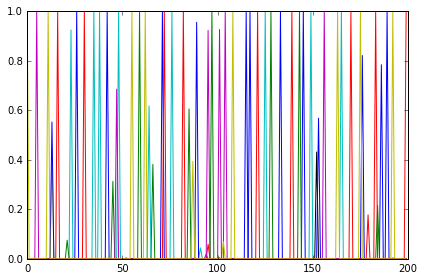

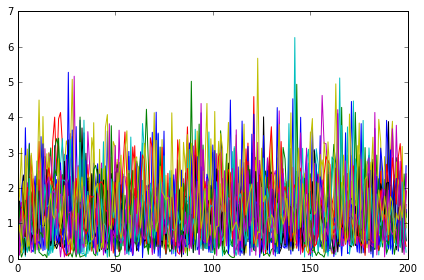

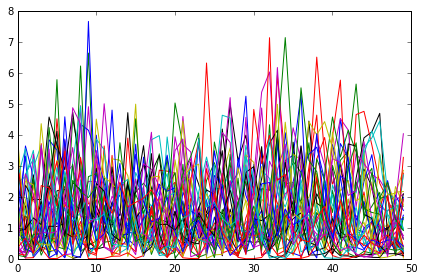

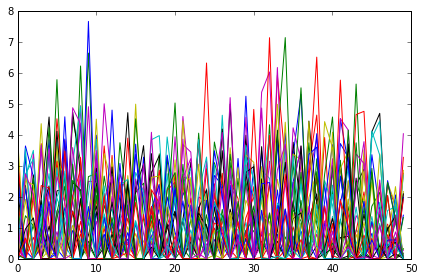

In [788]:

index = 10

plt.figure()
plt.plot(fmap1[index].T);

plt.figure()
plt.plot(active[index].T);

plt.figure()
plt.plot(active2[index].T);

plt.figure()
plt.plot(fmap2[index].T);


In [747]:


# deconvolution layer 1
input_var1 = T.tensor4('fmap')
shape1 = list(fmap1.shape)
shape1[0] = None
input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                      filter_size=network['conv1'].filter_size,
                                      W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv, # 
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)

prediction = get_output(deconv1)
reconstruction = theano.function([input_var1], prediction, allow_input_downcast=True)
X2 = np.squeeze(reconstruction(fmap1.astype(np.float32)))

In [611]:
x.shape

(4, 200, 1)

# Reconstruction with inverse function and psuedoinverse weights

In [535]:
W1 = network['conv1'].W.get_value()
W2 = network['conv2'].W.get_value()

print W1.shape

(20, 4, 15, 1)


In [536]:
def pseudoinverse_filter(W1):
    weight = np.squeeze(W1)

    W1_inv = []
    for i in range(len(weight)):
        W1_inv.append(np.linalg.pinv(weight[i]))
    W1_inv = np.array(W1_inv, dtype=theano.config.floatX)
    W1_inv = np.expand_dims(W1_inv,3).transpose([2,0,1,3])
    W1_inv = theano.shared(W1_inv)
    return W1_inv

W1_inv = pseudoinverse_filter(W1)
W2_inv = pseudoinverse_filter(W2)


In [558]:
fmaps2.shape

(210001, 40, 50, 1)

In [565]:

fmaps2 = get_feature_maps(network['conv2_active'], nnmodel.input_var, train[0])

shape2 = list(fmaps2.shape)
shape2[0] = None
input_var2 = T.tensor4('fmap')
input2 = InputLayer(tuple(shape2), input_var=input_var2)
unpool2 = Upscale1DLayer(input2, scale_factor=2)
unpool2 = ExpressionLayer(unpool2, lambda X: T.log(T.exp(X)-1), output_shape='auto')
unpool2 = BiasLayer(unpool2, b=-network['conv2_bias'].b)
deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                      filter_size=network['conv2'].filter_size,
                                      W=W2_inv,
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
unpool1 = Upscale1DLayer(deconv2, scale_factor=2)
unpool1 = ExpressionLayer(unpool1, lambda X: T.log(T.exp(X)-1), output_shape='auto')
unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                      filter_size=network['conv1'].filter_size,
                                      W=W1_inv,
                                      b=None, 
                                      pad='same',
                                      nonlinearity=None, flip_filters=True)
prediction = get_output(deconv1)
reconstruction = theano.function([input_var2], prediction, allow_input_downcast=True)

In [566]:
print fmaps2.shape
print get_output_shape(deconv2)
print get_output_shape(deconv1)


(210001, 40, 50, 1)
(None, 20, 100, 1)
(None, 4, 200, 1)


In [641]:
num_data = 10000
X = fmaps2[range(num_data)]

X2 = np.squeeze(reconstruction(X))
print X2.shape

labels = np.argmax(train[1][range(num_data)],axis=1)

ValueError: GpuElemwise. Input dimension mis-match. Input 2 (indices start at 0) has shape[1] == 20, but the output's size on that axis is 40.
Apply node that caused the error: GpuElemwise{Composite{(log((i0 + exp(i1))) + i2)}}[(0, 1)](CudaNdarrayConstant{[[[[-0.99999988]]]]}, GpuFromHost.0, GpuElemwise{neg,no_inplace}.0)
Toposort index: 18
Inputs types: [CudaNdarrayType(float32, (True, True, True, True)), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, (True, False, True, True))]
Inputs shapes: [(1, 1, 1, 1), (10000, 40, 50, 1), (1, 20, 1, 1)]
Inputs strides: [(0, 0, 0, 0), (2000, 50, 1, 0), (0, 1, 0, 0)]
Inputs values: [CudaNdarray([[[[-0.99999988]]]]), 'not shown', 'not shown']
Outputs clients: [[GpuContiguous(GpuElemwise{Composite{(log((i0 + exp(i1))) + i2)}}[(0, 1)].0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [556]:
X2[0].shape

(4, 400)

1


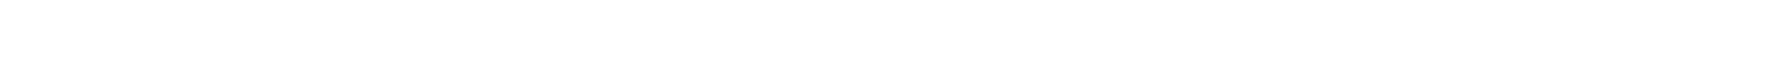

In [541]:
index = 17
x = X2[index]
print np.argmax(train[1][index])

height=300
bp_width=30
num_seq = X2.shape[2]
width = bp_width*num_seq
size = (25.,25.0)

MEAN = np.nanmean(x,axis=1)
x -= np.outer(MEAN, np.ones(x.shape[1]))
#STD = np.nanstd(x,axis=1)
#x /= np.outer(STD, np.ones(x.shape[1]))
x -= np.max(x, axis=0)
x = np.exp(x)
sumX = np.sum(x,axis=0)
x /= np.outer(np.ones(4),sumX)
logo = seq_logo(x, height, width, norm=0, rna=1, filepath='.')

fig = plt.figure(figsize=size)
plt.imshow(logo, interpolation='none') 
plt.axis('off');



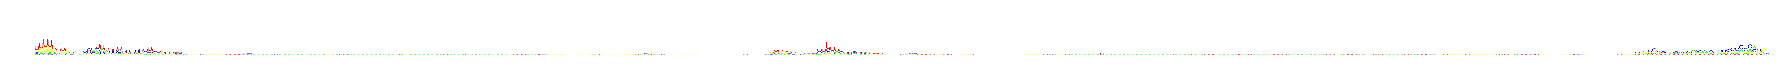

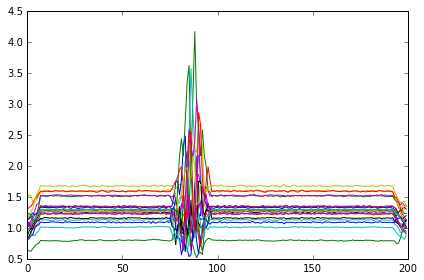

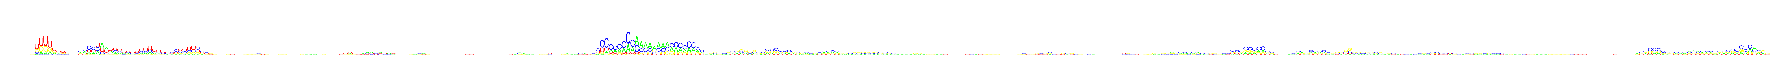

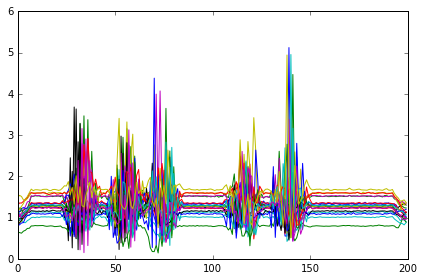

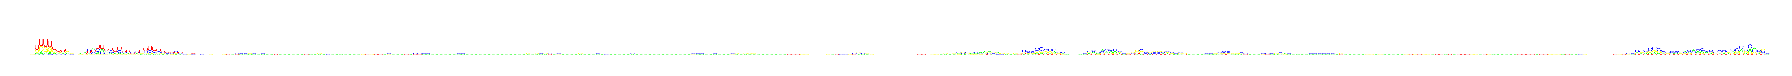

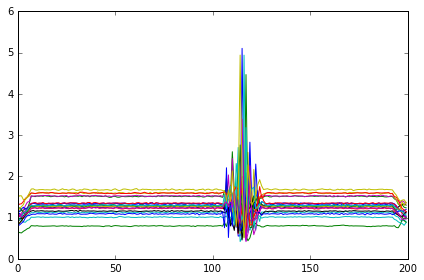

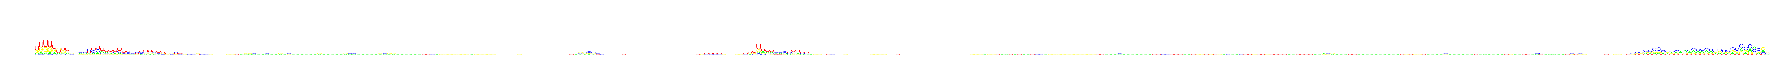

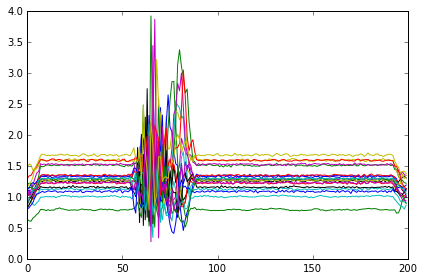

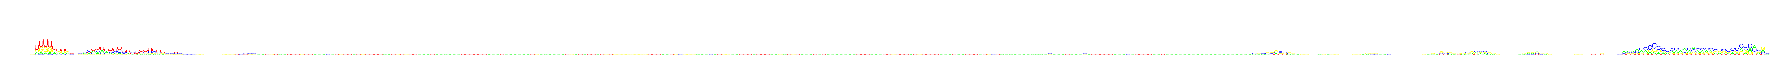

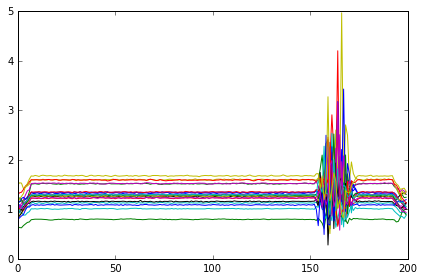

In [18]:
height=300
bp_width=30
num_seq = X2.shape[2]
width = bp_width*num_seq
size = (25.,10.0)

for j in range(5):
    index = np.where(labels==j)[0]
    index

    pwm = 0
    for i in index:
        if np.sum(np.isnan(X2[i])) == 0:
            pwm += X2[i]
    pwm /= len(index)

    sumX = np.sum(pwm,axis=0)
    normX = pwm/np.outer(np.ones(4),sumX)

    fig = plt.figure(figsize=size)
    #fig.set_size_inches(size[0],size[1], forward=True);
    logo = seq_logo(normX, height, width, norm=0, rna=1, filepath='.')
    plt.imshow(logo, interpolation='none') 
    plt.axis('off');
    
    fig = plt.figure()
    plt.plot(mean_activation[j].T)


In [575]:
print val
print np.linalg.pinv(np.expand_dims(val,1))

[ 0.01756981  0.90024269 -1.41152918 -0.5149169   2.36284423 -1.64241886
 -1.53486037  0.31698415 -1.51461899 -1.24397922 -0.62306017 -1.86059701
 -0.60219932  0.77593499  0.30548891  0.26302743  1.39526486  0.33144501
 -2.80472732  2.03873086]
[[ 0.0004787   0.02452744 -0.03845762 -0.0140291   0.06437655 -0.0447483
  -0.04181783  0.00863635 -0.04126634 -0.03389267 -0.0169755  -0.05069264
  -0.01640714  0.02114063  0.00832316  0.00716628  0.0380145   0.00903034
  -0.07641581  0.05554596]]


## Reconstruction with inverse function and max unpooling

In [571]:
def max_unpool_layer(active_layer, pool_layer, pool_size=4):
    
    active = get_feature_maps(active_layer, nnmodel.input_var, train[0])
    pool = get_feature_maps(pool_layer, nnmodel.input_var, train[0])
    
    fmap2 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k])
        mymap = np.squeeze(pool[k])

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index
        
        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap2.append(fmap_unpool)

    fmap2 = np.array(fmap2)
    fmap2 = np.expand_dims(fmap2, 3)
    return fmap2


def max_unpool_layer2(active_layer, pool_map, pool_size=4):
    
    active = get_feature_maps(active_layer, nnmodel.input_var, train[0])
    pool = pool_map
    
    fmap2 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k])
        mymap = np.squeeze(pool[k])

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index
        
        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap2.append(fmap_unpool)

    fmap2 = np.array(fmap2)
    fmap2 = np.expand_dims(fmap2, 3)
    return fmap2


def pseudoinverse_filter(W1):
    weight = np.squeeze(W1)

    W1_inv = []
    for i in range(len(weight)):
        W1_inv.append(np.linalg.pinv(weight[i]))
    W1_inv = np.array(W1_inv, dtype=theano.config.floatX)
    W1_inv = np.expand_dims(W1_inv,3).transpose([2,0,1,3])
    W1_inv = theano.shared(W1_inv)
    return W1_inv



def reconstruct_layer2(network, train):
    
    # psuedo-inverse filters
    W1 = network['conv1'].W.get_value()
    W2 = network['conv2'].W.get_value()
    W1_inv = pseudoinverse_filter(W1)
    W2_inv = pseudoinverse_filter(W2)

    # max-unpool layer 2
    fmap2 = max_unpool_layer(network['conv2_active'], network['conv2_pool'], pool_size=2)

    # deconvolution layer 2
    input_var2 = T.tensor4('fmap')
    shape2 = list(fmap2.shape)
    shape2[0] = None
    input2 = InputLayer(shape=tuple(shape2), input_var=input_var2)
    unpool2 = ExpressionLayer(input2, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    unpool2 = BiasLayer(unpool2, b=-network['conv2_bias'].b)
    deconv2 = Conv2DLayer(unpool2, num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
    prediction = get_output(deconv2)
    prediction = theano.function([input_var2], prediction, allow_input_downcast=True)
    intermediate = prediction(fmap2.astype(np.float32))
    
    
    MEAN = np.nanmean(x,axis=1)
    x -= np.outer(MEAN, np.ones(x.shape[1]))
    #STD = np.nanstd(x,axis=1)
    #x /= np.outer(STD, np.ones(x.shape[1]))
    x -= np.max(x, axis=)
    x = np.exp(x)
    sumX = np.sum(x,axis=0)
    x /= np.outer(np.ones(4),sumX)

    # max-unpool layer 1
    fmap1 = max_unpool_layer2(network['conv1_active'], intermediate, pool_size=4)
    print fmap1[1]
    1
    # deconvolution layer 1
    input_var1 = T.tensor4('fmap')
    shape1 = list(fmap1.shape)
    shape1[0] = None
    input1 = InputLayer(shape=tuple(shape1), input_var=input_var1)
    unpool1 = ExpressionLayer(input1, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    unpool1 = BiasLayer(unpool1, b=-network['conv1_bias'].b)
    deconv1 = Conv2DLayer(unpool1, num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W1_inv,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)

    prediction = get_output(deconv1)
    reconstruction = theano.function([input_var1], prediction, allow_input_downcast=True)
    X2 = np.squeeze(reconstruction(fmap1[range(1000)].astype(np.float32)))
    labels = np.argmax(train[1][range(1000)],axis=1)
    return X2, labels